In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

In [3]:
BASE_PATH = "/mnt/Data/data"
base_dir = Path(BASE_PATH).resolve()

In [4]:
config = {
    "config_folder": "../data/mearec",
    "recordings_folder": str(base_dir / "output/recordings"),
    "templates_folder": str(base_dir / "output/templates"),
}
output_base="output"
preprocessor="preprocessor"
evaluator="evaluator"
lcadc_suffix={
    True:"_lcadc",
    False:""
}
ul_suffix={
    6000:"",
    3000:"-bw-300-3000",
    1000:"-bw-300-1000"
}

def build_neo_folder(is_lcadc, bw):
    return str(base_dir / "".join([output_base,ul_suffix[bw]]) / "".join([preprocessor,lcadc_suffix[is_lcadc]]))

def build_eval_folder(is_lcadc, bw):
    return str(base_dir / "".join([output_base,ul_suffix[bw]]) / "".join([evaluator,lcadc_suffix[is_lcadc]]))


In [5]:
from eapprocessor.tools.load import load_neo

In [6]:
fs_list = [20000]
noise_levels = [5, 25]
resolution_list = [6,7,8]
bw_list =[1000,6000]
w=4
channel=27
spiketrain_idx=8
is_lcadc_list=[True, False]

In [7]:
def wrapper_load_neo(fs,noise_level,resolution,bw,is_lcadc):
    return load_neo(build_neo_folder(is_lcadc,bw),
                    resolution=resolution,
                    noise_level=noise_level,
                    fs=fs,
                    is_lcadc=is_lcadc)


In [8]:
import itertools

In [9]:
results=[]
for fs, noise_level, resolution, bw, is_lcadc in itertools.product(fs_list, noise_levels, 
                                                             resolution_list, bw_list, is_lcadc_list):
    results.append([fs, noise_level, resolution, bw, is_lcadc,
                    wrapper_load_neo(fs, noise_level,resolution,bw,is_lcadc)])

Search for pattern: *_6_5uV_20000Hz*
Loading file /mnt/Data/data/output-bw-300-1000/preprocessor_lcadc/preprocessed_neo_6_5uV_20000Hz_2022-08-08_13-49.h5
Search for pattern: *_6_5uV_20000Hz*
Loading file /mnt/Data/data/output-bw-300-1000/preprocessor/preprocessed_neo_6_5uV_20000Hz_2022-08-08_09-49.h5
Search for pattern: *_6_5uV_20000Hz*
Loading file /mnt/Data/data/output/preprocessor_lcadc/preprocessed_neo_6_5uV_20000Hz_2022-08-08_11-09.h5
Search for pattern: *_6_5uV_20000Hz*
Loading file /mnt/Data/data/output/preprocessor/preprocessed_neo_6_5uV_20000Hz_2022-08-08_09-15.h5
Search for pattern: *_7_5uV_20000Hz*
Loading file /mnt/Data/data/output-bw-300-1000/preprocessor_lcadc/preprocessed_neo_7_5uV_20000Hz_2022-08-08_13-40.h5
Search for pattern: *_7_5uV_20000Hz*
Loading file /mnt/Data/data/output-bw-300-1000/preprocessor/preprocessed_neo_7_5uV_20000Hz_2022-08-08_09-47.h5
Search for pattern: *_7_5uV_20000Hz*
Loading file /mnt/Data/data/output/preprocessor_lcadc/preprocessed_neo_7_5uV_2000

In [10]:
import pandas as pd
import numpy as np

In [11]:
df=pd.DataFrame(results, columns=["fs", "noise_level", "resolution", "bw", "is_lcadc", "result"])

In [12]:
df[["neo_obj", "neo_file"]]=pd.DataFrame(df["result"].tolist())
df.drop(columns=["result"],inplace=True)
df.head()

fs  noise_level  resolution    bw  is_lcadc   
0  20000            5           6  1000      True  \
1  20000            5           6  1000     False   
2  20000            5           6  6000      True   
3  20000            5           6  6000     False   
4  20000            5           7  1000      True   

                                             neo_obj   
0  {'adcinfo': {'resolution': 6, 'voltage_ref': 5...  \
1  {'adcinfo': {'resolution': 6, 'voltage_ref': 5...   
2  {'adcinfo': {'resolution': 6, 'voltage_ref': 5...   
3  {'adcinfo': {'resolution': 6, 'voltage_ref': 5...   
4  {'adcinfo': {'resolution': 7, 'voltage_ref': 5...   

                                            neo_file  
0  /mnt/Data/data/output-bw-300-1000/preprocessor...  
1  /mnt/Data/data/output-bw-300-1000/preprocessor...  
2  /mnt/Data/data/output/preprocessor_lcadc/prepr...  
3  /mnt/Data/data/output/preprocessor/preprocesse...  
4  /mnt/Data/data/output-bw-300-1000/preprocessor...

In [13]:
import h5py
import MEArec

In [14]:
def from_group_to_array(group):
    a=[[]]*len(group)
    for item in group:
        if isinstance(group[item], h5py._hl.dataset.Dataset):
            a[int(item)]=np.array(group[item])
        elif isinstance(group[item], h5py._hl.group.Group):
            a[int(item)]=from_group_to_array(group[item])
        
    return np.array(a,dtype=object)

def parse_rec_obj(rec_obj):
    return {
        "recordings": np.array(rec_obj.recordings).T,
        "spiketrains": rec_obj.spiketrains,
        "timestamps": np.array(rec_obj.timestamps)
    }


def parse_neo_obj(neo_obj):
    for key,val in neo_obj.items():
        #print(type(val))
        if isinstance(val, h5py._hl.dataset.Dataset):
            neo_obj[key]=np.array(val)
        elif isinstance(val, h5py._hl.group.Group):
            neo_obj[key]=from_group_to_array(val)
        elif isinstance(val, MEArec.generators.recordinggenerator.RecordingGenerator):
            neo_obj[key]=parse_rec_obj(val)
        
    return neo_obj

def obj_to_series(neo_obj):
    return pd.Series(parse_neo_obj(neo_obj))

In [15]:
ex=df["neo_obj"][0]
obj_to_series(ex)["recordings"]

{'recordings': array([[-7.2311153e+00, -2.7587960e+00, -2.3247678e+00, ...,
         -1.3574948e+00,  1.7728448e+00,  8.1556301e+00],
        [-1.1059606e+00, -6.4278569e+00,  1.8609204e+00, ...,
         -1.7591453e-01,  2.3866336e+00,  2.2236352e+00],
        [-4.0286905e-01, -1.6020525e+01,  3.1713166e+00, ...,
          1.0707998e+00, -3.0986516e+00,  8.7994337e-02],
        ...,
        [-2.9521513e+00,  1.7604921e+00,  6.8484459e+00, ...,
          5.5886769e+00, -2.0498977e+00,  1.0679415e+01],
        [-1.2358111e+00, -4.5244908e+00, -7.5556040e-03, ...,
          1.0344363e+01,  8.0520868e-02,  5.7061779e-01],
        [ 8.9501562e+00,  9.3797998e+00, -5.2109289e+00, ...,
         -5.0103865e+00, -2.5175805e+00,  1.7744868e+00]], dtype=float32),
 'spiketrains': [SpikeTrain
  annotations: {'bintype': 'E',
    'bursting': False,
    'cell_type': 'E',
    'exp_decay': None,
    'fr': 3.2502345269453023,
    'max_burst_duration': None,
    'max_spikes_per_burst': None,
    'mtype':

In [16]:
ex["recordings"]

{'recordings': array([[-7.2311153e+00, -2.7587960e+00, -2.3247678e+00, ...,
         -1.3574948e+00,  1.7728448e+00,  8.1556301e+00],
        [-1.1059606e+00, -6.4278569e+00,  1.8609204e+00, ...,
         -1.7591453e-01,  2.3866336e+00,  2.2236352e+00],
        [-4.0286905e-01, -1.6020525e+01,  3.1713166e+00, ...,
          1.0707998e+00, -3.0986516e+00,  8.7994337e-02],
        ...,
        [-2.9521513e+00,  1.7604921e+00,  6.8484459e+00, ...,
          5.5886769e+00, -2.0498977e+00,  1.0679415e+01],
        [-1.2358111e+00, -4.5244908e+00, -7.5556040e-03, ...,
          1.0344363e+01,  8.0520868e-02,  5.7061779e-01],
        [ 8.9501562e+00,  9.3797998e+00, -5.2109289e+00, ...,
         -5.0103865e+00, -2.5175805e+00,  1.7744868e+00]], dtype=float32),
 'spiketrains': [SpikeTrain
  annotations: {'bintype': 'E',
    'bursting': False,
    'cell_type': 'E',
    'exp_decay': None,
    'fr': 3.2502345269453023,
    'max_burst_duration': None,
    'max_spikes_per_burst': None,
    'mtype':

In [17]:
neodf=df["neo_obj"].apply(obj_to_series)
neodf.head()

adcinfo   
0  {'resolution': 6, 'voltage_ref': 500}  \
1  {'resolution': 6, 'voltage_ref': 500}   
2  {'resolution': 6, 'voltage_ref': 500}   
3  {'resolution': 6, 'voltage_ref': 500}   
4  {'resolution': 7, 'voltage_ref': 500}   

                                            channels   
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  \
1                                                NaN   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3                                                NaN   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                               lcadc   
0  [[32, 31, 32, 31, 32, 33, 35, 34, 33, 31, 29, ...  \
1                                                NaN   
2  [[32, 33, 32, 31, 32, 31, 32, 33, 32, 31, 32, ...   
3                                                NaN   
4  [[63, 65, 64, 65, 64, 65, 63, 65, 63, 65, 63, ...   

                                             indexes   
0  [[0, 374, 381, 495, 508, 518, 528, 531, 534, 5...  \
1                                                NaN   
2  [[0, 14, 17, 38, 39, 51, 53, 82, 84, 106, 109,...   
3                                                NaN   
4  [[0, 3, 4, 7, 9, 11, 12, 13, 17, 18, 19, 20, 2...   

                                          normalized   
0  [[0.0, -0.03125, 0.0, -0.03125, 0.0, 0.03125, ...  \
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, ...   
2  [[0.0, 0.03125, 0.0, -0.03125, 0.0, -0.03125, ...   
3  [[0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.03125, 0...   
4  [[-0.015625, 0.015625, 0.0, 0.015625, 0.0, 0.0...   

                                          recordings               w   
0  {'recordings': [[-7.2311153, -2.758796, -2.324...  [1, 4, 16, 32]  \
1  {'recordings': [[-7.2311153, -2.758796, -2.324...  [1, 4, 16, 32]   
2  {'recordings': [[-6.97424, -1.6472181, 1.96873...  [1, 4, 16, 32]   
3  {'recordings': [[-6.97424, -1.6472181, 1.96873...  [1, 4, 16, 32]   
4  {'recordings': [[-7.2311153, -2.758796, -2.324...  [1, 4, 16, 32]   

                                                 neo   
0  [[[0.0, 0.0009765625, -0.0009765625, 0.0009765...  \
1  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000976...   
2  [[[0.0, 0.0009765625, 0.0009765625, 0.00097656...   
3  [[[0.0, 0.0, 0.0, 0.0009765625, 0.0, 0.0, 0.00...   
4  [[[-0.015625, 0.000244140625, -0.000244140625,...   

                                                 adc  
0                                                NaN  
1  [[32, 32, 32, 32, 32, 32, 32, 33, 32, 32, 32, ...  
2                                                NaN  
3  [[32, 32, 32, 33, 32, 32, 33, 33, 32, 32, 32, ...  
4                                                NaN

In [18]:
def filter_list(arr, idx):
    if isinstance(arr,(list,np.ndarray)):
        return arr[idx];
    return arr

def filter_neo_df(row,channel,w):
    w_idx = np.where(row["w"]==w)[0][0]
    row["neo"]=row["neo"][w_idx]
    for col in ["lcadc", "indexes","normalized","adc","neo"]:
        row[col] = filter_list(row[col],channel)
    row["w"]=w
    row["channels"]=channel
    return row

In [19]:
neodf=df["neo_obj"].apply(obj_to_series)
neodf.apply(lambda x: filter_neo_df(x,channel,w),axis=1)
neodf.drop(columns=["lcadc","adc"],inplace=True)
neodf.head()

adcinfo channels   
0  {'resolution': 6, 'voltage_ref': 500}       27  \
1  {'resolution': 6, 'voltage_ref': 500}       27   
2  {'resolution': 6, 'voltage_ref': 500}       27   
3  {'resolution': 6, 'voltage_ref': 500}       27   
4  {'resolution': 7, 'voltage_ref': 500}       27   

                                             indexes   
0  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \
1                                                NaN   
2  [0, 3, 5, 14, 16, 17, 33, 34, 62, 65, 68, 72, ...   
3                                                NaN   
4  [0, 3, 5, 8, 14, 16, 33, 34, 58, 62, 63, 68, 6...   

                                          normalized   
0  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  \
1  [0.0, 0.0, 0.0, -0.03125, -0.03125, 0.0, 0.0, ...   
2  [0.0, -0.03125, 0.0, 0.03125, -0.03125, 0.0, -...   
3  [0.0, 0.03125, 0.0, -0.03125, -0.03125, 0.0, 0...   
4  [0.0, -0.03125, 0.0, -0.015625, 0.015625, 0.0,...   

                                          recordings  w   
0  {'recordings': [[-7.2311153, -2.758796, -2.324...  4  \
1  {'recordings': [[-7.2311153, -2.758796, -2.324...  4   
2  {'recordings': [[-6.97424, -1.6472181, 1.96873...  4   
3  {'recordings': [[-6.97424, -1.6472181, 1.96873...  4   
4  {'recordings': [[-7.2311153, -2.758796, -2.324...  4   

                                                 neo  
0  [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....  
1  [0.0, 0.0, 0.0, -0.03125, 0.0009765625, 0.0, 0...  
2  [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....  
3  [0.0, 0.03125, 0.0, -0.03125, 0.0009765625, 0....  
4  [0.0, -0.03125, 0.0, -0.015625, 0.000244140625...

In [20]:
ndf=df.assign(**neodf).drop(columns=["neo_obj"])
ndf.head()

fs  noise_level  resolution    bw  is_lcadc   
0  20000            5           6  1000      True  \
1  20000            5           6  1000     False   
2  20000            5           6  6000      True   
3  20000            5           6  6000     False   
4  20000            5           7  1000      True   

                                            neo_file   
0  /mnt/Data/data/output-bw-300-1000/preprocessor...  \
1  /mnt/Data/data/output-bw-300-1000/preprocessor...   
2  /mnt/Data/data/output/preprocessor_lcadc/prepr...   
3  /mnt/Data/data/output/preprocessor/preprocesse...   
4  /mnt/Data/data/output-bw-300-1000/preprocessor...   

                                 adcinfo channels   
0  {'resolution': 6, 'voltage_ref': 500}       27  \
1  {'resolution': 6, 'voltage_ref': 500}       27   
2  {'resolution': 6, 'voltage_ref': 500}       27   
3  {'resolution': 6, 'voltage_ref': 500}       27   
4  {'resolution': 7, 'voltage_ref': 500}       27   

                                             indexes   
0  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \
1                                                NaN   
2  [0, 3, 5, 14, 16, 17, 33, 34, 62, 65, 68, 72, ...   
3                                                NaN   
4  [0, 3, 5, 8, 14, 16, 33, 34, 58, 62, 63, 68, 6...   

                                          normalized   
0  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  \
1  [0.0, 0.0, 0.0, -0.03125, -0.03125, 0.0, 0.0, ...   
2  [0.0, -0.03125, 0.0, 0.03125, -0.03125, 0.0, -...   
3  [0.0, 0.03125, 0.0, -0.03125, -0.03125, 0.0, 0...   
4  [0.0, -0.03125, 0.0, -0.015625, 0.015625, 0.0,...   

                                          recordings  w   
0  {'recordings': [[-7.2311153, -2.758796, -2.324...  4  \
1  {'recordings': [[-7.2311153, -2.758796, -2.324...  4   
2  {'recordings': [[-6.97424, -1.6472181, 1.96873...  4   
3  {'recordings': [[-6.97424, -1.6472181, 1.96873...  4   
4  {'recordings': [[-7.2311153, -2.758796, -2.324...  4   

                                                 neo  
0  [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....  
1  [0.0, 0.0, 0.0, -0.03125, 0.0009765625, 0.0, 0...  
2  [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....  
3  [0.0, 0.03125, 0.0, -0.03125, 0.0009765625, 0....  
4  [0.0, -0.03125, 0.0, -0.015625, 0.000244140625...

In [21]:
def filter_rec_df(row,channel,spiketrain_idx):
    row["spiketrains"]=row["spiketrains"][spiketrain_idx]
    row["recordings"]=row["recordings"][channel]
    return row

In [22]:
recdf=ndf["recordings"].apply(pd.Series)
recdf.apply(lambda x: filter_rec_df(x,channel,spiketrain_idx),axis=1)
recdf.head()

recordings   
0  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  \
1  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   
2  [2.3110626, 9.914375, 1.8437628, -19.521925, -...   
3  [2.3110626, 9.914375, 1.8437628, -19.521925, -...   
4  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   

                                         spiketrains   
0  [0.043022192914784686 s, 0.09141615511014173 s...  \
1  [0.043022192914784686 s, 0.09141615511014173 s...   
2  [0.043022192914784686 s, 0.09141615511014173 s...   
3  [0.043022192914784686 s, 0.09141615511014173 s...   
4  [0.043022192914784686 s, 0.09141615511014173 s...   

                                          timestamps  
0  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...  
1  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...  
2  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...  
3  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...  
4  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...

In [23]:
nndf=ndf.drop(columns=["recordings"]).assign(**recdf)
nndf.head()

fs  noise_level  resolution    bw  is_lcadc   
0  20000            5           6  1000      True  \
1  20000            5           6  1000     False   
2  20000            5           6  6000      True   
3  20000            5           6  6000     False   
4  20000            5           7  1000      True   

                                            neo_file   
0  /mnt/Data/data/output-bw-300-1000/preprocessor...  \
1  /mnt/Data/data/output-bw-300-1000/preprocessor...   
2  /mnt/Data/data/output/preprocessor_lcadc/prepr...   
3  /mnt/Data/data/output/preprocessor/preprocesse...   
4  /mnt/Data/data/output-bw-300-1000/preprocessor...   

                                 adcinfo channels   
0  {'resolution': 6, 'voltage_ref': 500}       27  \
1  {'resolution': 6, 'voltage_ref': 500}       27   
2  {'resolution': 6, 'voltage_ref': 500}       27   
3  {'resolution': 6, 'voltage_ref': 500}       27   
4  {'resolution': 7, 'voltage_ref': 500}       27   

                                             indexes   
0  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \
1                                                NaN   
2  [0, 3, 5, 14, 16, 17, 33, 34, 62, 65, 68, 72, ...   
3                                                NaN   
4  [0, 3, 5, 8, 14, 16, 33, 34, 58, 62, 63, 68, 6...   

                                          normalized  w   
0  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  4  \
1  [0.0, 0.0, 0.0, -0.03125, -0.03125, 0.0, 0.0, ...  4   
2  [0.0, -0.03125, 0.0, 0.03125, -0.03125, 0.0, -...  4   
3  [0.0, 0.03125, 0.0, -0.03125, -0.03125, 0.0, 0...  4   
4  [0.0, -0.03125, 0.0, -0.015625, 0.015625, 0.0,...  4   

                                                 neo   
0  [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....  \
1  [0.0, 0.0, 0.0, -0.03125, 0.0009765625, 0.0, 0...   
2  [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....   
3  [0.0, 0.03125, 0.0, -0.03125, 0.0009765625, 0....   
4  [0.0, -0.03125, 0.0, -0.015625, 0.000244140625...   

                                          recordings   
0  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  \
1  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   
2  [2.3110626, 9.914375, 1.8437628, -19.521925, -...   
3  [2.3110626, 9.914375, 1.8437628, -19.521925, -...   
4  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   

                                         spiketrains   
0  [0.043022192914784686 s, 0.09141615511014173 s...  \
1  [0.043022192914784686 s, 0.09141615511014173 s...   
2  [0.043022192914784686 s, 0.09141615511014173 s...   
3  [0.043022192914784686 s, 0.09141615511014173 s...   
4  [0.043022192914784686 s, 0.09141615511014173 s...   

                                          timestamps  
0  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...  
1  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...  
2  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...  
3  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...  
4  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...

In [24]:
np.array(nndf["spiketrains"][0])

array([0.04302219, 0.09141616, 0.13770031, 0.24237551, 0.27664213,
       0.37804019, 0.51500822, 0.52655147, 0.59275611, 0.64264463,
       0.95683937, 0.96283024, 1.04895815, 1.07106541, 1.43739366,
       1.46774967, 1.47418014, 1.75754472, 1.80275632, 1.84835809,
       1.90016827, 2.09876206, 2.14551569, 2.14763561, 2.33754158,
       2.43285197, 2.52368504, 2.53139357, 2.63191922, 2.71719007,
       2.89443896, 2.94373778, 3.03001957, 3.17195324, 3.21098454,
       3.25725345, 3.26628734, 3.28089017, 3.34433759, 3.36886256,
       3.38284091, 3.43129189, 3.63980888, 3.65815215, 3.75125045,
       3.85062358, 3.95128354, 4.13030615, 4.15731659, 4.23604266,
       4.24910607, 4.33478013, 4.38134619, 4.42176159, 4.49383208,
       4.53893606, 4.64416471, 4.70165132, 4.8327213 , 4.86072926,
       4.94135792, 4.9671027 , 5.04201875, 5.07234758, 5.07673192,
       5.11739449, 5.20277141, 5.22339453, 5.29014328, 5.29912931,
       5.36940928, 5.37357099, 5.37695217, 5.42665772, 5.45130

In [25]:
breakpoints_file = str(base_dir / "breakpoints.csv")

In [26]:
bdf=pd.read_csv(breakpoints_file)
bdf["chunk_idx"]=bdf.index
bdf

l_limit_idx  h_limit_idx  l_limit  h_limit  chunk_idx
0            0        19982  0.00000  0.99910          0
1        19983        39979  0.99915  1.99895          1
2        39980        59873  1.99900  2.99365          2
3        59874        79974  2.99370  3.99870          3
4        79975        99914  3.99875  4.99570          4
5        99915       119995  4.99575  5.99975          5
6       119996       139756  5.99980  6.98780          6
7       139757       160047  6.98785  8.00235          7
8       160048       179914  8.00240  8.99570          8
9       179915       199999  8.99575  9.99995          9

In [27]:
edf=nndf.merge(bdf, how='cross')
edf.head()

fs  noise_level  resolution    bw  is_lcadc   
0  20000            5           6  1000      True  \
1  20000            5           6  1000      True   
2  20000            5           6  1000      True   
3  20000            5           6  1000      True   
4  20000            5           6  1000      True   

                                            neo_file   
0  /mnt/Data/data/output-bw-300-1000/preprocessor...  \
1  /mnt/Data/data/output-bw-300-1000/preprocessor...   
2  /mnt/Data/data/output-bw-300-1000/preprocessor...   
3  /mnt/Data/data/output-bw-300-1000/preprocessor...   
4  /mnt/Data/data/output-bw-300-1000/preprocessor...   

                                 adcinfo channels   
0  {'resolution': 6, 'voltage_ref': 500}       27  \
1  {'resolution': 6, 'voltage_ref': 500}       27   
2  {'resolution': 6, 'voltage_ref': 500}       27   
3  {'resolution': 6, 'voltage_ref': 500}       27   
4  {'resolution': 6, 'voltage_ref': 500}       27   

                                             indexes   
0  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \
1  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
2  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
3  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
4  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   

                                          normalized  w   
0  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  4  \
1  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  4   
2  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  4   
3  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  4   
4  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  4   

                                                 neo   
0  [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....  \
1  [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....   
2  [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....   
3  [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....   
4  [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....   

                                          recordings   
0  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  \
1  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   
2  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   
3  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   
4  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   

                                         spiketrains   
0  [0.043022192914784686 s, 0.09141615511014173 s...  \
1  [0.043022192914784686 s, 0.09141615511014173 s...   
2  [0.043022192914784686 s, 0.09141615511014173 s...   
3  [0.043022192914784686 s, 0.09141615511014173 s...   
4  [0.043022192914784686 s, 0.09141615511014173 s...   

                                          timestamps  l_limit_idx   
0  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...            0  \
1  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...        19983   
2  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...        39980   
3  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...        59874   
4  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...        79975   

   h_limit_idx  l_limit  h_limit  chunk_idx  
0        19982  0.00000  0.99910          0  
1        39979  0.99915  1.99895          1  
2        59873  1.99900  2.99365          2  
3        79974  2.99370  3.99870          3  
4        99914  3.99875  4.99570          4

In [28]:
edf["spiketrain_chunk"]=edf.apply(lambda x: 
                                  x["spiketrains"][(x["spiketrains"]> x["l_limit"])&
                                                   (x["spiketrains"]<= x["h_limit"])], axis=1)
edf

fs  noise_level  resolution    bw  is_lcadc   
0    20000            5           6  1000      True  \
1    20000            5           6  1000      True   
2    20000            5           6  1000      True   
3    20000            5           6  1000      True   
4    20000            5           6  1000      True   
..     ...          ...         ...   ...       ...   
235  20000           25           8  6000     False   
236  20000           25           8  6000     False   
237  20000           25           8  6000     False   
238  20000           25           8  6000     False   
239  20000           25           8  6000     False   

                                              neo_file   
0    /mnt/Data/data/output-bw-300-1000/preprocessor...  \
1    /mnt/Data/data/output-bw-300-1000/preprocessor...   
2    /mnt/Data/data/output-bw-300-1000/preprocessor...   
3    /mnt/Data/data/output-bw-300-1000/preprocessor...   
4    /mnt/Data/data/output-bw-300-1000/preprocessor...   
..                                                 ...   
235  /mnt/Data/data/output/preprocessor/preprocesse...   
236  /mnt/Data/data/output/preprocessor/preprocesse...   
237  /mnt/Data/data/output/preprocessor/preprocesse...   
238  /mnt/Data/data/output/preprocessor/preprocesse...   
239  /mnt/Data/data/output/preprocessor/preprocesse...   

                                   adcinfo channels   
0    {'resolution': 6, 'voltage_ref': 500}       27  \
1    {'resolution': 6, 'voltage_ref': 500}       27   
2    {'resolution': 6, 'voltage_ref': 500}       27   
3    {'resolution': 6, 'voltage_ref': 500}       27   
4    {'resolution': 6, 'voltage_ref': 500}       27   
..                                     ...      ...   
235  {'resolution': 8, 'voltage_ref': 500}       27   
236  {'resolution': 8, 'voltage_ref': 500}       27   
237  {'resolution': 8, 'voltage_ref': 500}       27   
238  {'resolution': 8, 'voltage_ref': 500}       27   
239  {'resolution': 8, 'voltage_ref': 500}       27   

                                               indexes   
0    [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \
1    [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
2    [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
3    [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
4    [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
..                                                 ...   
235                                                NaN   
236                                                NaN   
237                                                NaN   
238                                                NaN   
239                                                NaN   

                                            normalized  ...   
0    [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  \
1    [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   
2    [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   
3    [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   
4    [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   
..                                                 ...  ...   
235  [0.0234375, 0.1015625, 0.015625, -0.1953125, -...  ...   
236  [0.0234375, 0.1015625, 0.015625, -0.1953125, -...  ...   
237  [0.0234375, 0.1015625, 0.015625, -0.1953125, -...  ...   
238  [0.0234375, 0.1015625, 0.015625, -0.1953125, -...  ...   
239  [0.0234375, 0.1015625, 0.015625, -0.1953125, -...  ...   

                                                   neo   
0    [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....  \
1    [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....   
2    [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....   
3    [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....   
4    [0.0, -0.03125, 0.0, 0.03125, 0.0009765625, 0....   
..                                                 ...   
235  [0.0234375, 0.1015625, 0.015625, -0.1953125, 0...   
236  [0.0234375, 0.1015625, 0.015625, -0.1953125, 0...   
237  [0.02343

In [29]:
edf["recording_chunk"]=edf.apply(lambda x: 
                                  x["recordings"][x["l_limit_idx"]:x["h_limit_idx"]+1], axis=1)
edf.head()

fs  noise_level  resolution    bw  is_lcadc   
0  20000            5           6  1000      True  \
1  20000            5           6  1000      True   
2  20000            5           6  1000      True   
3  20000            5           6  1000      True   
4  20000            5           6  1000      True   

                                            neo_file   
0  /mnt/Data/data/output-bw-300-1000/preprocessor...  \
1  /mnt/Data/data/output-bw-300-1000/preprocessor...   
2  /mnt/Data/data/output-bw-300-1000/preprocessor...   
3  /mnt/Data/data/output-bw-300-1000/preprocessor...   
4  /mnt/Data/data/output-bw-300-1000/preprocessor...   

                                 adcinfo channels   
0  {'resolution': 6, 'voltage_ref': 500}       27  \
1  {'resolution': 6, 'voltage_ref': 500}       27   
2  {'resolution': 6, 'voltage_ref': 500}       27   
3  {'resolution': 6, 'voltage_ref': 500}       27   
4  {'resolution': 6, 'voltage_ref': 500}       27   

                                             indexes   
0  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \
1  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
2  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
3  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
4  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   

                                          normalized  ...   
0  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  \
1  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   
2  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   
3  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   
4  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   

                                          recordings   
0  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  \
1  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   
2  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   
3  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   
4  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   

                                         spiketrains   
0  [0.043022192914784686 s, 0.09141615511014173 s...  \
1  [0.043022192914784686 s, 0.09141615511014173 s...   
2  [0.043022192914784686 s, 0.09141615511014173 s...   
3  [0.043022192914784686 s, 0.09141615511014173 s...   
4  [0.043022192914784686 s, 0.09141615511014173 s...   

                                          timestamps l_limit_idx h_limit_idx   
0  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...           0       19982  \
1  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...       19983       39979   
2  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...       39980       59873   
3  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...       59874       79974   
4  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...       79975       99914   

   l_limit  h_limit  chunk_idx   
0  0.00000  0.99910          0  \
1  0.99915  1.99895          1   
2  1.99900  2.99365          2   
3  2.99370  3.99870          3   
4  3.99875  4.99570          4   

                                    spiketrain_chunk   
0  [0.043022192914784686 s, 0.09141615511014173 s...  \
1  [1.0489581465556497 s, 1.0710654084903757 s, 1...   
2  [2.098762063079152 s, 2.145515693894677 s, 2.1...   
3  [3.030019569592036 s, 3.1719532393467604 s, 3....   
4  [4.130306152649535 s, 4.157316593457093 s, 4.2...   

                                     recording_chunk  
0  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  
1  [-2.9933784, -0.6633488, -11.669907, 2.781744,...  
2  [0.7094796, -0.18536192, 0.8696826, 4.3431587,...  
3  [-4.2250457, -0.7141621, -11.509712, -9.980713...  
4  [3.4243042, 2.591824, 7.650317, 6.207827, 13.2...  

[5 rows x 22 columns]

In [30]:
rec=edf.loc[(edf["chunk_idx"]==5)&(edf["noise_level"]==5)&(edf["bw"]==6000)].reset_index()["recording_chunk"][0]

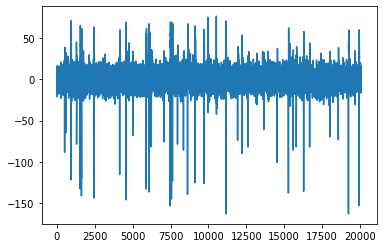

In [31]:
import matplotlib.pylab as plt
plt.plot(rec)

In [32]:
from eapprocessor.evaluator.spikes import estimate_sample_spikes, comparison_detection_spiketrain

In [33]:
fs_df = edf.drop_duplicates(subset=["fs"]).copy()
fs_df

fs  noise_level  resolution    bw  is_lcadc   
0  20000            5           6  1000      True  \

                                            neo_file   
0  /mnt/Data/data/output-bw-300-1000/preprocessor...  \

                                 adcinfo channels   
0  {'resolution': 6, 'voltage_ref': 500}       27  \

                                             indexes   
0  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \

                                          normalized  ...   
0  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  \

                                          recordings   
0  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  \

                                         spiketrains   
0  [0.043022192914784686 s, 0.09141615511014173 s...  \

                                          timestamps l_limit_idx h_limit_idx   
0  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...           0       19982  \

   l_limit  h_limit  chunk_idx   
0      0.0   0.9991          0  \

                                    spiketrain_chunk   
0  [0.043022192914784686 s, 0.09141615511014173 s...  \

                                     recording_chunk  
0  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  

[1 rows x 22 columns]

In [34]:
fs_df["estimated_index"] = fs_df.apply(lambda x: estimate_sample_spikes(spikes= x["spiketrains"],
                                                                         timestamps=x["timestamps"]),
                                       axis=1)

In [35]:
fs_df[["spike_indexes", "err_list"]] = pd.DataFrame(fs_df["estimated_index"].tolist(), index=fs_df.index)
fs_df

fs  noise_level  resolution    bw  is_lcadc   
0  20000            5           6  1000      True  \

                                            neo_file   
0  /mnt/Data/data/output-bw-300-1000/preprocessor...  \

                                 adcinfo channels   
0  {'resolution': 6, 'voltage_ref': 500}       27  \

                                             indexes   
0  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \

                                          normalized  ... l_limit_idx   
0  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...           0  \

  h_limit_idx l_limit h_limit chunk_idx   
0       19982     0.0  0.9991         0  \

                                    spiketrain_chunk   
0  [0.043022192914784686 s, 0.09141615511014173 s...  \

                                     recording_chunk   
0  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  \

                                     estimated_index   
0  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  \

                                       spike_indexes   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \

                                            err_list  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[1 rows x 25 columns]

In [36]:
fs_df["spike_indexes"].apply(np.max)

0    1.0
Name: spike_indexes, dtype: float64

In [37]:
nedf = edf.join(fs_df.set_index("fs")["spike_indexes"], on="fs", how='left')
nedf.head()

fs  noise_level  resolution    bw  is_lcadc   
0  20000            5           6  1000      True  \
1  20000            5           6  1000      True   
2  20000            5           6  1000      True   
3  20000            5           6  1000      True   
4  20000            5           6  1000      True   

                                            neo_file   
0  /mnt/Data/data/output-bw-300-1000/preprocessor...  \
1  /mnt/Data/data/output-bw-300-1000/preprocessor...   
2  /mnt/Data/data/output-bw-300-1000/preprocessor...   
3  /mnt/Data/data/output-bw-300-1000/preprocessor...   
4  /mnt/Data/data/output-bw-300-1000/preprocessor...   

                                 adcinfo channels   
0  {'resolution': 6, 'voltage_ref': 500}       27  \
1  {'resolution': 6, 'voltage_ref': 500}       27   
2  {'resolution': 6, 'voltage_ref': 500}       27   
3  {'resolution': 6, 'voltage_ref': 500}       27   
4  {'resolution': 6, 'voltage_ref': 500}       27   

                                             indexes   
0  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \
1  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
2  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
3  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
4  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   

                                          normalized  ...   
0  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  \
1  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   
2  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   
3  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   
4  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   

                                         spiketrains   
0  [0.043022192914784686 s, 0.09141615511014173 s...  \
1  [0.043022192914784686 s, 0.09141615511014173 s...   
2  [0.043022192914784686 s, 0.09141615511014173 s...   
3  [0.043022192914784686 s, 0.09141615511014173 s...   
4  [0.043022192914784686 s, 0.09141615511014173 s...   

                                          timestamps l_limit_idx h_limit_idx   
0  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...           0       19982  \
1  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...       19983       39979   
2  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...       39980       59873   
3  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...       59874       79974   
4  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...       79975       99914   

   l_limit  h_limit  chunk_idx   
0  0.00000  0.99910          0  \
1  0.99915  1.99895          1   
2  1.99900  2.99365          2   
3  2.99370  3.99870          3   
4  3.99875  4.99570          4   

                                    spiketrain_chunk   
0  [0.043022192914784686 s, 0.09141615511014173 s...  \
1  [1.0489581465556497 s, 1.0710654084903757 s, 1...   
2  [2.098762063079152 s, 2.145515693894677 s, 2.1...   
3  [3.030019569592036 s, 3.1719532393467604 s, 3....   
4  [4.130306152649535 s, 4.157316593457093 s, 4.2...   

                                     recording_chunk   
0  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  \
1  [-2.9933784, -0.6633488, -11.669907, 2.781744,...   
2  [0.7094796, -0.18536192, 0.8696826, 4.3431587,...   
3  [-4.2250457, -0.7141621, -11.509712, -9.980713...   
4  [3.4243042, 2.591824, 7.650317, 6.207827, 13.2...   

                                       spike_indexes  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[5 rows x 23 columns]

### Get evaluation files

In [38]:
from eapprocessor.tools.load import load_neo, load_count_evaluation, get_evaluation_files

In [39]:
neo_df = nedf.drop_duplicates(subset=["neo_file"]).copy()
neo_df

fs  noise_level  resolution    bw  is_lcadc   
0    20000            5           6  1000      True  \
10   20000            5           6  1000     False   
20   20000            5           6  6000      True   
30   20000            5           6  6000     False   
40   20000            5           7  1000      True   
50   20000            5           7  1000     False   
60   20000            5           7  6000      True   
70   20000            5           7  6000     False   
80   20000            5           8  1000      True   
90   20000            5           8  1000     False   
100  20000            5           8  6000      True   
110  20000            5           8  6000     False   
120  20000           25           6  1000      True   
130  20000           25           6  1000     False   
140  20000           25           6  6000      True   
150  20000           25           6  6000     False   
160  20000           25           7  1000      True   
170  20000           25           7  1000     False   
180  20000           25           7  6000      True   
190  20000           25           7  6000     False   
200  20000           25           8  1000      True   
210  20000           25           8  1000     False   
220  20000           25           8  6000      True   
230  20000           25           8  6000     False   

                                              neo_file   
0    /mnt/Data/data/output-bw-300-1000/preprocessor...  \
10   /mnt/Data/data/output-bw-300-1000/preprocessor...   
20   /mnt/Data/data/output/preprocessor_lcadc/prepr...   
30   /mnt/Data/data/output/preprocessor/preprocesse...   
40   /mnt/Data/data/output-bw-300-1000/preprocessor...   
50   /mnt/Data/data/output-bw-300-1000/preprocessor...   
60   /mnt/Data/data/output/preprocessor_lcadc/prepr...   
70   /mnt/Data/data/output/preprocessor/preprocesse...   
80   /mnt/Data/data/output-bw-300-1000/preprocessor...   
90   /mnt/Data/data/output-bw-300-1000/preprocessor...   
100  /mnt/Data/data/output/preprocessor_lcadc/prepr...   
110  /mnt/Data/data/output/preprocessor/preprocesse...   
120  /mnt/Data/data/output-bw-300-1000/preprocessor...   
130  /mnt/Data/data/output-bw-300-1000/preprocessor...   
140  /mnt/Data/data/output/preprocessor_lcadc/prepr...   
150  /mnt/Data/data/output/preprocessor/preprocesse...   
160  /mnt/Data/data/output-bw-300-1000/preprocessor...   
170  /mnt/Data/data/output-bw-300-1000/preprocessor...   
180  /mnt/Data/data/output/preprocessor_lcadc/prepr...   
190  /mnt/Data/data/output/preprocessor/preprocesse...   
200  /mnt/Data/data/output-bw-300-1000/preprocessor...   
210  /mnt/Data/data/output-bw-300-1000/preprocessor...   
220  /mnt/Data/data/output/preprocessor_lcadc/prepr...   
230  /mnt/Data/data/output/preprocessor/preprocesse...   

                                   adcinfo channels   
0    {'resolution': 6, 'voltage_ref': 500}       27  \
10   {'resolution': 6, 'voltage_ref': 500}       27   
20   {'resolution': 6, 'voltage_ref': 500}       27   
30   {'resolution': 6, 'voltage_ref': 500}       27   
40   {'resolution': 7, 'voltage_ref': 500}       27   
50   {'resolution': 7, 'voltage_ref': 500}       27   
60   {'resolution': 7, 'voltage_ref': 500}       27   
70   {'resolution': 7, 'voltage_ref': 500}       27   
80   {'resolution': 8, 'voltage_ref': 500}       27   
90   {'resolution': 8, 'voltage_ref': 500}       27   
100  {'resolution': 8, 'voltage_ref': 500}       27   
110  {'resolution': 8, 'voltage_ref': 500}       27   
120  {'resolution': 6, 'voltage_ref': 500}       27   
130  {'resolution': 6, 'voltage_ref': 500}       27   
140  {'resolution': 6, 'voltage_ref': 500}       27   
150  {'resolution': 6, 'voltage_ref': 500}       27   
160  {'resolution': 7, 'voltage_ref': 500}       27   
170  {'resolution': 7, 'voltage_ref': 500}       27   
180  {'resolution': 7, 'voltage_ref': 500}       27   
190  {'resolution': 7, 'voltage_ref': 500}       27   
200  {'resolution': 8, 'vo

In [40]:
neo_df["evaluation_files"]=neo_df.apply(lambda x: get_evaluation_files(
    build_eval_folder(x["is_lcadc"], x["bw"]),
    sourcefile=x["neo_file"]), axis=1)
neo_df

Search for pattern: *
Filename found 3 files with source /mnt/Data/data/output-bw-300-1000/preprocessor_lcadc/preprocessed_neo_6_5uV_20000Hz_2022-08-08_13-49.h5
[PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5')]
Search for pattern: *
Filename found 3 files with source /mnt/Data/data/output-bw-300-1000/preprocessor/preprocessed_neo_6_5uV_20000Hz_2022-08-08_09-49.h5
[PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_17-01.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_17-01.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/e

Filename found 3 files with source /mnt/Data/data/output-bw-300-1000/preprocessor_lcadc/preprocessed_neo_7_25uV_20000Hz_2022-08-08_13-43.h5
[PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5')]
Search for pattern: *
Filename found 3 files with source /mnt/Data/data/output-bw-300-1000/preprocessor/preprocessed_neo_7_25uV_20000Hz_2022-08-08_09-48.h5
[PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_16-56.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_16-56.h5'), PosixPath('/mnt/Data/data/output-bw-300-1000/evaluator/thresh

fs  noise_level  resolution    bw  is_lcadc   
0    20000            5           6  1000      True  \
10   20000            5           6  1000     False   
20   20000            5           6  6000      True   
30   20000            5           6  6000     False   
40   20000            5           7  1000      True   
50   20000            5           7  1000     False   
60   20000            5           7  6000      True   
70   20000            5           7  6000     False   
80   20000            5           8  1000      True   
90   20000            5           8  1000     False   
100  20000            5           8  6000      True   
110  20000            5           8  6000     False   
120  20000           25           6  1000      True   
130  20000           25           6  1000     False   
140  20000           25           6  6000      True   
150  20000           25           6  6000     False   
160  20000           25           7  1000      True   
170  20000           25           7  1000     False   
180  20000           25           7  6000      True   
190  20000           25           7  6000     False   
200  20000           25           8  1000      True   
210  20000           25           8  1000     False   
220  20000           25           8  6000      True   
230  20000           25           8  6000     False   

                                              neo_file   
0    /mnt/Data/data/output-bw-300-1000/preprocessor...  \
10   /mnt/Data/data/output-bw-300-1000/preprocessor...   
20   /mnt/Data/data/output/preprocessor_lcadc/prepr...   
30   /mnt/Data/data/output/preprocessor/preprocesse...   
40   /mnt/Data/data/output-bw-300-1000/preprocessor...   
50   /mnt/Data/data/output-bw-300-1000/preprocessor...   
60   /mnt/Data/data/output/preprocessor_lcadc/prepr...   
70   /mnt/Data/data/output/preprocessor/preprocesse...   
80   /mnt/Data/data/output-bw-300-1000/preprocessor...   
90   /mnt/Data/data/output-bw-300-1000/preprocessor...   
100  /mnt/Data/data/output/preprocessor_lcadc/prepr...   
110  /mnt/Data/data/output/preprocessor/preprocesse...   
120  /mnt/Data/data/output-bw-300-1000/preprocessor...   
130  /mnt/Data/data/output-bw-300-1000/preprocessor...   
140  /mnt/Data/data/output/preprocessor_lcadc/prepr...   
150  /mnt/Data/data/output/preprocessor/preprocesse...   
160  /mnt/Data/data/output-bw-300-1000/preprocessor...   
170  /mnt/Data/data/output-bw-300-1000/preprocessor...   
180  /mnt/Data/data/output/preprocessor_lcadc/prepr...   
190  /mnt/Data/data/output/preprocessor/preprocesse...   
200  /mnt/Data/data/output-bw-300-1000/preprocessor...   
210  /mnt/Data/data/output-bw-300-1000/preprocessor...   
220  /mnt/Data/data/output/preprocessor_lcadc/prepr...   
230  /mnt/Data/data/output/preprocessor/preprocesse...   

                                   adcinfo channels   
0    {'resolution': 6, 'voltage_ref': 500}       27  \
10   {'resolution': 6, 'voltage_ref': 500}       27   
20   {'resolution': 6, 'voltage_ref': 500}       27   
30   {'resolution': 6, 'voltage_ref': 500}       27   
40   {'resolution': 7, 'voltage_ref': 500}       27   
50   {'resolution': 7, 'voltage_ref': 500}       27   
60   {'resolution': 7, 'voltage_ref': 500}       27   
70   {'resolution': 7, 'voltage_ref': 500}       27   
80   {'resolution': 8, 'voltage_ref': 500}       27   
90   {'resolution': 8, 'voltage_ref': 500}       27   
100  {'resolution': 8, 'voltage_ref': 500}       27   
110  {'resolution': 8, 'voltage_ref': 500}       27   
120  {'resolution': 6, 'voltage_ref': 500}       27   
130  {'resolution': 6, 'voltage_ref': 500}       27   
140  {'resolution': 6, 'voltage_ref': 500}       27   
150  {'resolution': 6, 'voltage_ref': 500}       27   
160  {'resolution': 7, 'voltage_ref': 500}       27   
170  {'resolution': 7, 'voltage_ref': 500}       27   
180  {'resolution': 7, 'voltage_ref': 500}       27   
190  {'resolution': 7, 'voltage_ref': 500}       27   
200  {'resolution': 8, 'vo

In [41]:
eedf = nedf.join(neo_df.set_index("neo_file")["evaluation_files"], on="neo_file", how='left')
eedf.head()

fs  noise_level  resolution    bw  is_lcadc   
0  20000            5           6  1000      True  \
1  20000            5           6  1000      True   
2  20000            5           6  1000      True   
3  20000            5           6  1000      True   
4  20000            5           6  1000      True   

                                            neo_file   
0  /mnt/Data/data/output-bw-300-1000/preprocessor...  \
1  /mnt/Data/data/output-bw-300-1000/preprocessor...   
2  /mnt/Data/data/output-bw-300-1000/preprocessor...   
3  /mnt/Data/data/output-bw-300-1000/preprocessor...   
4  /mnt/Data/data/output-bw-300-1000/preprocessor...   

                                 adcinfo channels   
0  {'resolution': 6, 'voltage_ref': 500}       27  \
1  {'resolution': 6, 'voltage_ref': 500}       27   
2  {'resolution': 6, 'voltage_ref': 500}       27   
3  {'resolution': 6, 'voltage_ref': 500}       27   
4  {'resolution': 6, 'voltage_ref': 500}       27   

                                             indexes   
0  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \
1  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
2  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
3  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
4  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   

                                          normalized  ...   
0  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  \
1  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   
2  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   
3  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   
4  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...   

                                          timestamps l_limit_idx h_limit_idx   
0  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...           0       19982  \
1  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...       19983       39979   
2  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...       39980       59873   
3  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...       59874       79974   
4  [0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...       79975       99914   

   l_limit  h_limit  chunk_idx   
0  0.00000  0.99910          0  \
1  0.99915  1.99895          1   
2  1.99900  2.99365          2   
3  2.99370  3.99870          3   
4  3.99875  4.99570          4   

                                    spiketrain_chunk   
0  [0.043022192914784686 s, 0.09141615511014173 s...  \
1  [1.0489581465556497 s, 1.0710654084903757 s, 1...   
2  [2.098762063079152 s, 2.145515693894677 s, 2.1...   
3  [3.030019569592036 s, 3.1719532393467604 s, 3....   
4  [4.130306152649535 s, 4.157316593457093 s, 4.2...   

                                     recording_chunk   
0  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  \
1  [-2.9933784, -0.6633488, -11.669907, 2.781744,...   
2  [0.7094796, -0.18536192, 0.8696826, 4.3431587,...   
3  [-4.2250457, -0.7141621, -11.509712, -9.980713...   
4  [3.4243042, 2.591824, 7.650317, 6.207827, 13.2...   

                                       spike_indexes   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                    evaluation_files  
0  {'recordings_file': /mnt/Data/data/output-bw-3...  
1  {'recordings_file': /mnt/Data/data/output-bw-3...  
2  {'recordings_file': /mnt/Data/data/output-bw-3...  
3  {'recordings_file': /mnt/Data/data/output-bw-3...  
4  {'recordings_file': /mnt/Data/data/output-bw-3...  

[5 rows x 24 columns]

In [42]:
eedf["evaluation_files"] = eedf["evaluation_files"].apply(lambda x: list(x.items()))
needf = eedf.explode("evaluation_files")
needf[["type", "evaluation_file"]] = pd.DataFrame(needf['evaluation_files'].tolist(), index=needf.index)
needf.drop(columns=["evaluation_files"],inplace=True)

In [43]:
types =[
    "recordings",
    "normalized",
    "neo"
]
types_files = [
    "recordings_file",
    "normalized_file",
    "neo_file"
]
map_file_to_type = dict(zip(types_files,types))
needf["n_type"]=needf["type"].map(map_file_to_type)
needf.drop(columns=["type"], inplace=True)
needf.rename(columns={"n_type":"type"}, inplace=True)

In [44]:
from eapprocessor.process import get_results_evaluation_dataset, get_results_evaluation_dataset_array

In [45]:
def wrapper_function(evaluator_file, neo_file, is_lcadc, current_type, indexes, l_limit_idx, h_limit_idx, i, total):
    print(f"Starting execution {i}/{total}")
    if current_type == "recordings":
        is_lcadc=False
    is_neo = (current_type == "neo")
    print(f"Evaluating with eval_file={evaluator_file}, type={current_type}")
    eval_result = get_results_evaluation_dataset(evaluator_file, 
                                     indexes,
                                     channel_idx=channel_idx,
                                     window_time=TIME_WINDOW,
                                     origin_file=neo_file,
                                     is_neo=is_neo,
                                     is_lcadc=is_lcadc,
                                     l_limit_idx=l_limit_idx,
                                     h_limit_idx=h_limit_idx) 
    print(f"Finished execution {i}/{total}")
    return eval_result

In [46]:
needf.columns

Index(['fs', 'noise_level', 'resolution', 'bw', 'is_lcadc', 'neo_file',
       'adcinfo', 'channels', 'indexes', 'normalized', 'w', 'neo',
       'recordings', 'spiketrains', 'timestamps', 'l_limit_idx', 'h_limit_idx',
       'l_limit', 'h_limit', 'chunk_idx', 'spiketrain_chunk',
       'recording_chunk', 'spike_indexes', 'evaluation_file', 'type'],
      dtype='object')

In [47]:
needf.reset_index(drop=True, inplace=True)

In [48]:
channel_idx=1
TIME_WINDOW = 2.5e-3
wrapper_function(needf["evaluation_file"][0],
                 needf["neo_file"][0],
                 needf["is_lcadc"][0],
                 needf["type"][0],
                 [needf["spike_indexes"][0]],
                 needf["l_limit_idx"][0],
                 needf["h_limit_idx"][0],
                 1,1)

Starting execution 1/1
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 1/1


array([[{'truepositive': 12, 'falsepositive': 388, 'falsenegative': 0, 'truenegative': 0}],
       [{'truepositive': 12, 'falsepositive': 388, 'falsenegative': 0, 'truenegative': 0}],
       [{'truepositive': 12, 'falsepositive': 388, 'falsenegative': 0, 'truenegative': 0}],
       [{'truepositive': 12, 'falsepositive': 379, 'falsenegative': 0, 'truenegative': 9}],
       [{'truepositive': 12, 'falsepositive': 262, 'falsenegative': 0, 'truenegative': 126}],
       [{'truepositive': 12, 'falsepositive': 132, 'falsenegative': 0, 'truenegative': 256}],
       [{'truepositive': 12, 'falsepositive': 95, 'falsenegative': 0, 'truenegative': 293}],
       [{'truepositive': 12, 'falsepositive': 74, 'falsenegative': 0, 'truenegative': 314}],
       [{'truepositive': 12, 'falsepositive': 62, 'falsenegative': 0, 'truenegative': 326}],
       [{'truepositive': 12, 'falsepositive': 53, 'falsenegative': 0, 'truenegative': 335}],
       [{'truepositive': 12, 'falsepositive': 47, 'falsenegative': 0, 't

In [49]:
needf["spike_indexes"][0].shape

(200000,)

In [50]:
wrapper_function(needf["evaluation_file"][0],
                 needf["neo_file"][0],
                 needf["is_lcadc"][0],
                 needf["type"][0],
                 [needf["spike_indexes"][0]],
                 None,
                 None,
                 1,1)

Starting execution 1/1
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=recordings
lower limit: None
higher limit: None
Shape evaluation: (2, 50, 200000)
Finished execution 1/1


array([[{'truepositive': 140, 'falsepositive': 3858, 'falsenegative': 0, 'truenegative': 1}],
       [{'truepositive': 140, 'falsepositive': 3858, 'falsenegative': 0, 'truenegative': 1}],
       [{'truepositive': 140, 'falsepositive': 3858, 'falsenegative': 0, 'truenegative': 1}],
       [{'truepositive': 140, 'falsepositive': 3764, 'falsenegative': 0, 'truenegative': 95}],
       [{'truepositive': 140, 'falsepositive': 2539, 'falsenegative': 0, 'truenegative': 1320}],
       [{'truepositive': 140, 'falsepositive': 1311, 'falsenegative': 0, 'truenegative': 2548}],
       [{'truepositive': 140, 'falsepositive': 868, 'falsenegative': 0, 'truenegative': 2991}],
       [{'truepositive': 140, 'falsepositive': 667, 'falsenegative': 0, 'truenegative': 3192}],
       [{'truepositive': 140, 'falsepositive': 519, 'falsenegative': 0, 'truenegative': 3340}],
       [{'truepositive': 140, 'falsepositive': 420, 'falsenegative': 0, 'truenegative': 3439}],
       [{'truepositive': 140, 'falsepositive'

In [51]:
needf["results"]=needf.apply(lambda x: wrapper_function(x["evaluation_file"],
                 x["neo_file"],
                 x["is_lcadc"],
                 x["type"],
                 [x["spike_indexes"]],
                 x["l_limit_idx"],
                 x["h_limit_idx"],
                 x.name,len(needf)), axis=1)

Starting execution 0/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 0/720
Starting execution 1/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ...

lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 1/720
Starting execution 2/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 0., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0.

lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 2/720
Starting execution 3/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=recordings
lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 3/720
Starting execution 4/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.])

lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 4/720
Starting execution 5/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 0., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0.

{'adcinfo': {'resolution': 6, 'voltage_ref': 500}, 'channels': <HDF5 dataset "channels": shape (32,), type "<i8">, 'lcadc': [<HDF5 dataset "0": shape (5650,), type "<i8">, <HDF5 dataset "1": shape (4921,), type "<i8">, <HDF5 dataset "2": shape (4971,), type "<i8">, <HDF5 dataset "3": shape (4995,), type "<i8">, <HDF5 dataset "4": shape (6089,), type "<i8">, <HDF5 dataset "5": shape (8775,), type "<i8">, <HDF5 dataset "6": shape (7815,), type "<i8">, <HDF5 dataset "7": shape (7666,), type "<i8">, <HDF5 dataset "8": shape (7657,), type "<i8">, <HDF5 dataset "9": shape (8525,), type "<i8">, <HDF5 dataset "10": shape (5485,), type "<i8">, <HDF5 dataset "11": shape (5253,), type "<i8">, <HDF5 dataset "12": shape (4927,), type "<i8">, <HDF5 dataset "13": shape (5199,), type "<i8">, <HDF5 dataset "14": shape (5799,), type "<i8">, <HDF5 dataset "15": shape (7441,), type "<i8">, <HDF5 dataset "16": shape (8616,), type "<i8">, <HDF5 dataset "17": shape (9920,), type "<i8">, <HDF5 dataset "18": s

lower limit: 19983
higher limit: 39979
Shape evaluation: (4, 2, 50, 19997)
Finished execution 5/720
Starting execution 6/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=recordings
lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 6/720
Starting execution 7/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 

lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 7/720
Starting execution 8/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 0., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0.

{'adcinfo': {'resolution': 6, 'voltage_ref': 500}, 'channels': <HDF5 dataset "channels": shape (32,), type "<i8">, 'lcadc': [<HDF5 dataset "0": shape (5650,), type "<i8">, <HDF5 dataset "1": shape (4921,), type "<i8">, <HDF5 dataset "2": shape (4971,), type "<i8">, <HDF5 dataset "3": shape (4995,), type "<i8">, <HDF5 dataset "4": shape (6089,), type "<i8">, <HDF5 dataset "5": shape (8775,), type "<i8">, <HDF5 dataset "6": shape (7815,), type "<i8">, <HDF5 dataset "7": shape (7666,), type "<i8">, <HDF5 dataset "8": shape (7657,), type "<i8">, <HDF5 dataset "9": shape (8525,), type "<i8">, <HDF5 dataset "10": shape (5485,), type "<i8">, <HDF5 dataset "11": shape (5253,), type "<i8">, <HDF5 dataset "12": shape (4927,), type "<i8">, <HDF5 dataset "13": shape (5199,), type "<i8">, <HDF5 dataset "14": shape (5799,), type "<i8">, <HDF5 dataset "15": shape (7441,), type "<i8">, <HDF5 dataset "16": shape (8616,), type "<i8">, <HDF5 dataset "17": shape (9920,), type "<i8">, <HDF5 dataset "18": s

lower limit: 39980
higher limit: 59873
Shape evaluation: (4, 2, 50, 19894)
Finished execution 8/720
Starting execution 9/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=recordings
lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 9/720
Starting execution 10/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0.,

lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 10/720
Starting execution 11/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 0., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 

{'adcinfo': {'resolution': 6, 'voltage_ref': 500}, 'channels': <HDF5 dataset "channels": shape (32,), type "<i8">, 'lcadc': [<HDF5 dataset "0": shape (5650,), type "<i8">, <HDF5 dataset "1": shape (4921,), type "<i8">, <HDF5 dataset "2": shape (4971,), type "<i8">, <HDF5 dataset "3": shape (4995,), type "<i8">, <HDF5 dataset "4": shape (6089,), type "<i8">, <HDF5 dataset "5": shape (8775,), type "<i8">, <HDF5 dataset "6": shape (7815,), type "<i8">, <HDF5 dataset "7": shape (7666,), type "<i8">, <HDF5 dataset "8": shape (7657,), type "<i8">, <HDF5 dataset "9": shape (8525,), type "<i8">, <HDF5 dataset "10": shape (5485,), type "<i8">, <HDF5 dataset "11": shape (5253,), type "<i8">, <HDF5 dataset "12": shape (4927,), type "<i8">, <HDF5 dataset "13": shape (5199,), type "<i8">, <HDF5 dataset "14": shape (5799,), type "<i8">, <HDF5 dataset "15": shape (7441,), type "<i8">, <HDF5 dataset "16": shape (8616,), type "<i8">, <HDF5 dataset "17": shape (9920,), type "<i8">, <HDF5 dataset "18": s

lower limit: 59874
higher limit: 79974
Shape evaluation: (4, 2, 50, 20101)
Finished execution 11/720
Starting execution 12/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=recordings
lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 12/720
Starting execution 13/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 

lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 13/720
Starting execution 14/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 0., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 

{'adcinfo': {'resolution': 6, 'voltage_ref': 500}, 'channels': <HDF5 dataset "channels": shape (32,), type "<i8">, 'lcadc': [<HDF5 dataset "0": shape (5650,), type "<i8">, <HDF5 dataset "1": shape (4921,), type "<i8">, <HDF5 dataset "2": shape (4971,), type "<i8">, <HDF5 dataset "3": shape (4995,), type "<i8">, <HDF5 dataset "4": shape (6089,), type "<i8">, <HDF5 dataset "5": shape (8775,), type "<i8">, <HDF5 dataset "6": shape (7815,), type "<i8">, <HDF5 dataset "7": shape (7666,), type "<i8">, <HDF5 dataset "8": shape (7657,), type "<i8">, <HDF5 dataset "9": shape (8525,), type "<i8">, <HDF5 dataset "10": shape (5485,), type "<i8">, <HDF5 dataset "11": shape (5253,), type "<i8">, <HDF5 dataset "12": shape (4927,), type "<i8">, <HDF5 dataset "13": shape (5199,), type "<i8">, <HDF5 dataset "14": shape (5799,), type "<i8">, <HDF5 dataset "15": shape (7441,), type "<i8">, <HDF5 dataset "16": shape (8616,), type "<i8">, <HDF5 dataset "17": shape (9920,), type "<i8">, <HDF5 dataset "18": s

lower limit: 79975
higher limit: 99914
Shape evaluation: (4, 2, 50, 19940)
Finished execution 14/720
Starting execution 15/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=recordings
lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 15/720
Starting execution 16/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0.,

lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 16/720
Starting execution 17/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 0., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ...,

lower limit: 99915
higher limit: 119995
Shape evaluation: (4, 2, 50, 20081)
Finished execution 17/720
Starting execution 18/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=recordings
lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 18/720
Starting execution 19/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0

lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 19/720
Starting execution 20/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 0., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ...

lower limit: 119996
higher limit: 139756
Shape evaluation: (4, 2, 50, 19761)
Finished execution 20/720
Starting execution 21/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=recordings
lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 21/720
Starting execution 22/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 

lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 22/720
Starting execution 23/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 0., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ...

lower limit: 139757
higher limit: 160047
Shape evaluation: (4, 2, 50, 20291)
Finished execution 23/720
Starting execution 24/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=recordings
lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 24/720
Starting execution 25/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 

lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 25/720
Starting execution 26/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 0., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ...

lower limit: 160048
higher limit: 179914
Shape evaluation: (4, 2, 50, 19867)
Finished execution 26/720
Starting execution 27/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=recordings
lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 27/720
Starting execution 28/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 

lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 28/720
Starting execution 29/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_19-54.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 0., 1., 1.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ...

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 29/720
Starting execution 30/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_17-01.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 30/720
Starting execution 31/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_17-01.h5, type=normalized
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 31/720
Starting execution 32/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_17-01.h5, type=neo
lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 32/720
Starting execution 33/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 59/720
Starting execution 60/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 60/720
Starting execution 61/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0

Original indexes
[array([     0,     14,     17, ..., 199979, 199980, 199983]), array([     0,     67,     71, ..., 199977, 199989, 199994]), array([     0,      1,      2, ..., 199987, 199995, 199997]), array([     0,      8,     11, ..., 199990, 199992, 199996]), array([     0,     34,     37, ..., 199962, 199979, 199984]), array([     0,      8,     10, ..., 199990, 199995, 199996]), array([     0,      8,     15, ..., 199995, 199998, 199999]), array([     0,      9,     16, ..., 199975, 199993, 199999]), array([     0,     42,     47, ..., 199974, 199991, 199993]), array([     0,     17,     18, ..., 199970, 199972, 199973]), array([     0,     32,     34, ..., 199993, 199998, 199999]), array([     0,    111,    112, ..., 199855, 199935, 199938]), array([     0,      3,      8, ..., 199967, 199971, 199974]), array([     0,      9,     10, ..., 199945, 199948, 199950]), array([     0,      1,      5, ..., 199990, 199993, 199994]), array([     0,      6,      9, ..., 199982, 199985, 

lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 62/720
Starting execution 63/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=recordings
lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 63/720
Starting execution 64/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0.,

lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 64/720
Starting execution 65/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=neo
Evaluation indexes


[[[array([1., 1., 0., ..., 0., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.

lower limit: 19983
higher limit: 39979
Shape evaluation: (4, 2, 50, 19997)
Finished execution 65/720
Starting execution 66/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=recordings
lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 66/720
Starting execution 67/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0.,

lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 67/720
Starting execution 68/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=neo
Evaluation indexes


[[[array([1., 1., 0., ..., 0., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.

lower limit: 39980
higher limit: 59873
Shape evaluation: (4, 2, 50, 19894)
Finished execution 68/720
Starting execution 69/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=recordings
lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 69/720
Starting execution 70/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0.,

Original indexes
[array([     0,     14,     17, ..., 199979, 199980, 199983]), array([     0,     67,     71, ..., 199977, 199989, 199994]), array([     0,      1,      2, ..., 199987, 199995, 199997]), array([     0,      8,     11, ..., 199990, 199992, 199996]), array([     0,     34,     37, ..., 199962, 199979, 199984]), array([     0,      8,     10, ..., 199990, 199995, 199996]), array([     0,      8,     15, ..., 199995, 199998, 199999]), array([     0,      9,     16, ..., 199975, 199993, 199999]), array([     0,     42,     47, ..., 199974, 199991, 199993]), array([     0,     17,     18, ..., 199970, 199972, 199973]), array([     0,     32,     34, ..., 199993, 199998, 199999]), array([     0,    111,    112, ..., 199855, 199935, 199938]), array([     0,      3,      8, ..., 199967, 199971, 199974]), array([     0,      9,     10, ..., 199945, 199948, 199950]), array([     0,      1,      5, ..., 199990, 199993, 199994]), array([     0,      6,      9, ..., 199982, 199985, 

lower limit: 59874
higher limit: 79974
Shape evaluation: (4, 2, 50, 20101)
Finished execution 71/720
Starting execution 72/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=recordings
lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 72/720
Starting execution 73/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0.,

lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 73/720
Starting execution 74/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=neo
Evaluation indexes
[[[array([1., 1., 0., ..., 0., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])

lower limit: 79975
higher limit: 99914
Shape evaluation: (4, 2, 50, 19940)
Finished execution 74/720
Starting execution 75/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=recordings
lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 75/720
Starting execution 76/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0.

lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 76/720
Starting execution 77/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=neo
Evaluation indexes
[[[array([1., 1., 0., ..., 0., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]

lower limit: 99915
higher limit: 119995
Shape evaluation: (4, 2, 50, 20081)
Finished execution 77/720
Starting execution 78/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=recordings
lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 78/720
Starting execution 79/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 

lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 79/720
Starting execution 80/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=neo
Evaluation indexes
[[[array([1., 1., 0., ..., 0., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.

lower limit: 119996
higher limit: 139756
Shape evaluation: (4, 2, 50, 19761)
Finished execution 80/720
Starting execution 81/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=recordings
lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 81/720
Starting execution 82/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.,

Original indexes
[array([     0,     14,     17, ..., 199979, 199980, 199983]), array([     0,     67,     71, ..., 199977, 199989, 199994]), array([     0,      1,      2, ..., 199987, 199995, 199997]), array([     0,      8,     11, ..., 199990, 199992, 199996]), array([     0,     34,     37, ..., 199962, 199979, 199984]), array([     0,      8,     10, ..., 199990, 199995, 199996]), array([     0,      8,     15, ..., 199995, 199998, 199999]), array([     0,      9,     16, ..., 199975, 199993, 199999]), array([     0,     42,     47, ..., 199974, 199991, 199993]), array([     0,     17,     18, ..., 199970, 199972, 199973]), array([     0,     32,     34, ..., 199993, 199998, 199999]), array([     0,    111,    112, ..., 199855, 199935, 199938]), array([     0,      3,      8, ..., 199967, 199971, 199974]), array([     0,      9,     10, ..., 199945, 199948, 199950]), array([     0,      1,      5, ..., 199990, 199993, 199994]), array([     0,      6,      9, ..., 199982, 199985, 

lower limit: 139757
higher limit: 160047
Shape evaluation: (4, 2, 50, 20291)
Finished execution 83/720
Starting execution 84/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=recordings
lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 84/720
Starting execution 85/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.,

lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 85/720
Starting execution 86/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=neo
Evaluation indexes
[[[array([1., 1., 0., ..., 0., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.

lower limit: 160048
higher limit: 179914
Shape evaluation: (4, 2, 50, 19867)
Finished execution 86/720
Starting execution 87/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=recordings
lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 87/720
Starting execution 88/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.,

lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 88/720
Starting execution 89/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_18-21.h5, type=neo
Evaluation indexes
[[[array([1., 1., 0., ..., 0., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 89/720
Starting execution 90/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_recordings_subset_50th_6_5uV_20000Hz_2022-08-08_14-36.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 90/720
Starting execution 91/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_normalized_subset_50th_6_5uV_20000Hz_2022-08-08_14-36.h5, type=normalized
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 91/720
Starting execution 92/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_neo_subset_50th_6_5uV_20000Hz_2022-08-08_14-36.h5, type=neo
lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 92/720
Starting execution 93/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_recordings_subset_50th_6_5uV

lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 120/720
Starting execution 121/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0.

Original indexes
[array([     0,      3,      4, ..., 199996, 199997, 199999]), array([     0,      3,     12, ..., 199994, 199995, 199998]), array([     0,      1,      2, ..., 199993, 199994, 199997]), array([     0,      8,     11, ..., 199991, 199992, 199993]), array([     0,      4,      7, ..., 199992, 199995, 199999]), array([     0,      1,      5, ..., 199991, 199995, 199996]), array([     0,      8,     10, ..., 199995, 199996, 199998]), array([     0,      9,     10, ..., 199994, 199996, 199999]), array([     0,      3,      4, ..., 199983, 199991, 199993]), array([     0,      3,     12, ..., 199982, 199992, 199994]), array([     0,      3,      4, ..., 199994, 199995, 199998]), array([     0,      6,      8, ..., 199977, 199998, 199999]), array([     0,      3,      4, ..., 199996, 199997, 199999]), array([     0,      9,     10, ..., 199975, 199990, 199998]), array([     0,      1,      2, ..., 199993, 199994, 199998]), array([     0,      3,      4, ..., 199981, 199994, 

lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 122/720
Starting execution 123/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=recordings
lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 123/720
Starting execution 124/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 

lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 124/720
Starting execution 125/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=neo
Evaluation indexes
[[[array([1., 1., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ...

lower limit: 19983
higher limit: 39979
Shape evaluation: (4, 2, 50, 19997)
Finished execution 125/720
Starting execution 126/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=recordings
lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 126/720
Starting execution 127/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 

lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 127/720
Starting execution 128/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=neo
Evaluation indexes
[[[array([1., 1., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ...

lower limit: 39980
higher limit: 59873
Shape evaluation: (4, 2, 50, 19894)
Finished execution 128/720
Starting execution 129/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=recordings
lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 129/720
Starting execution 130/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 

Original indexes
[array([     0,      3,      4, ..., 199996, 199997, 199999]), array([     0,      3,     12, ..., 199994, 199995, 199998]), array([     0,      1,      2, ..., 199993, 199994, 199997]), array([     0,      8,     11, ..., 199991, 199992, 199993]), array([     0,      4,      7, ..., 199992, 199995, 199999]), array([     0,      1,      5, ..., 199991, 199995, 199996]), array([     0,      8,     10, ..., 199995, 199996, 199998]), array([     0,      9,     10, ..., 199994, 199996, 199999]), array([     0,      3,      4, ..., 199983, 199991, 199993]), array([     0,      3,     12, ..., 199982, 199992, 199994]), array([     0,      3,      4, ..., 199994, 199995, 199998]), array([     0,      6,      8, ..., 199977, 199998, 199999]), array([     0,      3,      4, ..., 199996, 199997, 199999]), array([     0,      9,     10, ..., 199975, 199990, 199998]), array([     0,      1,      2, ..., 199993, 199994, 199998]), array([     0,      3,      4, ..., 199981, 199994, 

Original indexes
[array([     0,      3,      4, ..., 199996, 199997, 199999]), array([     0,      3,     12, ..., 199994, 199995, 199998]), array([     0,      1,      2, ..., 199993, 199994, 199997]), array([     0,      8,     11, ..., 199991, 199992, 199993]), array([     0,      4,      7, ..., 199992, 199995, 199999]), array([     0,      1,      5, ..., 199991, 199995, 199996]), array([     0,      8,     10, ..., 199995, 199996, 199998]), array([     0,      9,     10, ..., 199994, 199996, 199999]), array([     0,      3,      4, ..., 199983, 199991, 199993]), array([     0,      3,     12, ..., 199982, 199992, 199994]), array([     0,      3,      4, ..., 199994, 199995, 199998]), array([     0,      6,      8, ..., 199977, 199998, 199999]), array([     0,      3,      4, ..., 199996, 199997, 199999]), array([     0,      9,     10, ..., 199975, 199990, 199998]), array([     0,      1,      2, ..., 199993, 199994, 199998]), array([     0,      3,      4, ..., 199981, 199994, 

lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 133/720
Starting execution 134/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=neo
Evaluation indexes
[[[array([1., 1., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ...

lower limit: 79975
higher limit: 99914
Shape evaluation: (4, 2, 50, 19940)
Finished execution 134/720
Starting execution 135/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=recordings
lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 135/720
Starting execution 136/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ...,

lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 136/720
Starting execution 137/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=neo
Evaluation indexes
[[[array([1., 1., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..

lower limit: 99915
higher limit: 119995
Shape evaluation: (4, 2, 50, 20081)
Finished execution 137/720
Starting execution 138/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=recordings
lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 138/720
Starting execution 139/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..

lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 139/720
Starting execution 140/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=neo
Evaluation indexes
[[[array([1., 1., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 119996
higher limit: 139756
Shape evaluation: (4, 2, 50, 19761)
Finished execution 140/720
Starting execution 141/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=recordings
lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 141/720
Starting execution 142/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 142/720
Starting execution 143/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=neo
Evaluation indexes
[[[array([1., 1., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 139757
higher limit: 160047
Shape evaluation: (4, 2, 50, 20291)
Finished execution 143/720
Starting execution 144/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=recordings
lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 144/720
Starting execution 145/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

Original indexes
[array([     0,      3,      4, ..., 199996, 199997, 199999]), array([     0,      3,     12, ..., 199994, 199995, 199998]), array([     0,      1,      2, ..., 199993, 199994, 199997]), array([     0,      8,     11, ..., 199991, 199992, 199993]), array([     0,      4,      7, ..., 199992, 199995, 199999]), array([     0,      1,      5, ..., 199991, 199995, 199996]), array([     0,      8,     10, ..., 199995, 199996, 199998]), array([     0,      9,     10, ..., 199994, 199996, 199999]), array([     0,      3,      4, ..., 199983, 199991, 199993]), array([     0,      3,     12, ..., 199982, 199992, 199994]), array([     0,      3,      4, ..., 199994, 199995, 199998]), array([     0,      6,      8, ..., 199977, 199998, 199999]), array([     0,      3,      4, ..., 199996, 199997, 199999]), array([     0,      9,     10, ..., 199975, 199990, 199998]), array([     0,      1,      2, ..., 199993, 199994, 199998]), array([     0,      3,      4, ..., 199981, 199994, 

lower limit: 160048
higher limit: 179914
Shape evaluation: (4, 2, 50, 19867)
Finished execution 146/720
Starting execution 147/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=recordings
lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 147/720
Starting execution 148/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 1., 0., ..., 1., 1., 1.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 148/720
Starting execution 149/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_19-50.h5, type=neo
Evaluation indexes
[[[array([1., 1., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 149/720
Starting execution 150/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_16-55.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 150/720
Starting execution 151/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_16-55.h5, type=normalized
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 151/720
Starting execution 152/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_16-55.h5, type=neo
lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 152/720
Starting execution 153/720
Evaluating with eval_file=/mnt/Data/data/output-bw-3

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 179/720
Starting execution 180/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 180/720
Starting execution 181/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0

Original indexes
[array([     0,      2,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199994, 199995, 199998]), array([     0,      1,      2, ..., 199994, 199995, 199997]), array([     0,      5,      7, ..., 199996, 199997, 199998]), array([     0,      3,      4, ..., 199992, 199995, 199999]), array([     0,      1,      5, ..., 199995, 199996, 199999]), array([     0,      8,      9, ..., 199996, 199998, 199999]), array([     0,      9,     10, ..., 199996, 199997, 199999]), array([     0,      3,      5, ..., 199993, 199997, 199999]), array([     0,      2,     12, ..., 199997, 199998, 199999]), array([     0,      3,      4, ..., 199997, 199998, 199999]), array([     0,      3,      8, ..., 199993, 199998, 199999]), array([     0,      1,      3, ..., 199995, 199997, 199999]), array([     0,      1,      4, ..., 199975, 199989, 199999]), array([     0,      1,      3, ..., 199994, 199997, 199999]), array([     0,      2,      3, ..., 199996, 199997, 

lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 182/720
Starting execution 183/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=recordings
lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 183/720
Starting execution 184/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0.,

lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 184/720
Starting execution 185/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.

lower limit: 19983
higher limit: 39979
Shape evaluation: (4, 2, 50, 19997)
Finished execution 185/720
Starting execution 186/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=recordings
lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 186/720
Starting execution 187/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.,

Original indexes
[array([     0,      2,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199994, 199995, 199998]), array([     0,      1,      2, ..., 199994, 199995, 199997]), array([     0,      5,      7, ..., 199996, 199997, 199998]), array([     0,      3,      4, ..., 199992, 199995, 199999]), array([     0,      1,      5, ..., 199995, 199996, 199999]), array([     0,      8,      9, ..., 199996, 199998, 199999]), array([     0,      9,     10, ..., 199996, 199997, 199999]), array([     0,      3,      5, ..., 199993, 199997, 199999]), array([     0,      2,     12, ..., 199997, 199998, 199999]), array([     0,      3,      4, ..., 199997, 199998, 199999]), array([     0,      3,      8, ..., 199993, 199998, 199999]), array([     0,      1,      3, ..., 199995, 199997, 199999]), array([     0,      1,      4, ..., 199975, 199989, 199999]), array([     0,      1,      3, ..., 199994, 199997, 199999]), array([     0,      2,      3, ..., 199996, 199997, 

Original indexes
[array([     0,      2,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199994, 199995, 199998]), array([     0,      1,      2, ..., 199994, 199995, 199997]), array([     0,      5,      7, ..., 199996, 199997, 199998]), array([     0,      3,      4, ..., 199992, 199995, 199999]), array([     0,      1,      5, ..., 199995, 199996, 199999]), array([     0,      8,      9, ..., 199996, 199998, 199999]), array([     0,      9,     10, ..., 199996, 199997, 199999]), array([     0,      3,      5, ..., 199993, 199997, 199999]), array([     0,      2,     12, ..., 199997, 199998, 199999]), array([     0,      3,      4, ..., 199997, 199998, 199999]), array([     0,      3,      8, ..., 199993, 199998, 199999]), array([     0,      1,      3, ..., 199995, 199997, 199999]), array([     0,      1,      4, ..., 199975, 199989, 199999]), array([     0,      1,      3, ..., 199994, 199997, 199999]), array([     0,      2,      3, ..., 199996, 199997, 

[array([     0,      2,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199994, 199995, 199998]), array([     0,      1,      2, ..., 199994, 199995, 199997]), array([     0,      5,      7, ..., 199996, 199997, 199998]), array([     0,      3,      4, ..., 199992, 199995, 199999]), array([     0,      1,      5, ..., 199995, 199996, 199999]), array([     0,      8,      9, ..., 199996, 199998, 199999]), array([     0,      9,     10, ..., 199996, 199997, 199999]), array([     0,      3,      5, ..., 199993, 199997, 199999]), array([     0,      2,     12, ..., 199997, 199998, 199999]), array([     0,      3,      4, ..., 199997, 199998, 199999]), array([     0,      3,      8, ..., 199993, 199998, 199999]), array([     0,      1,      3, ..., 199995, 199997, 199999]), array([     0,      1,      4, ..., 199975, 199989, 199999]), array([     0,      1,      3, ..., 199994, 199997, 199999]), array([     0,      2,      3, ..., 199996, 199997, 199999]), array([

lower limit: 59874
higher limit: 79974
Shape evaluation: (4, 2, 50, 20101)
Finished execution 191/720
Starting execution 192/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=recordings
lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 192/720
Starting execution 193/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.,

lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 193/720
Starting execution 194/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.

lower limit: 79975
higher limit: 99914
Shape evaluation: (4, 2, 50, 19940)
Finished execution 194/720
Starting execution 195/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=recordings
lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 195/720
Starting execution 196/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.

lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 196/720
Starting execution 197/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0

lower limit: 99915
higher limit: 119995
Shape evaluation: (4, 2, 50, 20081)
Finished execution 197/720
Starting execution 198/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=recordings
lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 198/720
Starting execution 199/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([

lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 199/720
Starting execution 200/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 

lower limit: 119996
higher limit: 139756
Shape evaluation: (4, 2, 50, 19761)
Finished execution 200/720
Starting execution 201/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=recordings
lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 201/720
Starting execution 202/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array(

lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 202/720
Starting execution 203/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 

lower limit: 139757
higher limit: 160047
Shape evaluation: (4, 2, 50, 20291)
Finished execution 203/720
Starting execution 204/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=recordings
lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 204/720
Starting execution 205/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array(

lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 205/720
Starting execution 206/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 

lower limit: 160048
higher limit: 179914
Shape evaluation: (4, 2, 50, 19867)
Finished execution 206/720
Starting execution 207/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=recordings
lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 207/720
Starting execution 208/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array(

lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 208/720
Starting execution 209/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_18-15.h5, type=neo
Evaluation indexes
[[[array([1., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 0., 1., 0.]), array([0., 1., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 209/720
Starting execution 210/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_recordings_subset_50th_7_5uV_20000Hz_2022-08-08_14-30.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 210/720
Starting execution 211/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_normalized_subset_50th_7_5uV_20000Hz_2022-08-08_14-30.h5, type=normalized
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 211/720
Starting execution 212/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_neo_subset_50th_7_5uV_20000Hz_2022-08-08_14-30.h5, type=neo
lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 212/720
Starting execution 213/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_recordings_subset_50

lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 240/720
Starting execution 241/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0.

Original indexes
[array([     0,      1,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199994, 199995, 199997]), array([     0,      1,      2, ..., 199993, 199994, 199997]), array([     0,      5,      7, ..., 199994, 199996, 199997]), array([     0,      1,      4, ..., 199995, 199996, 199999]), array([     0,      1,      3, ..., 199995, 199996, 199999]), array([     0,      1,      2, ..., 199996, 199998, 199999]), array([     0,      2,      4, ..., 199997, 199998, 199999]), array([     0,      3,      4, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199995, 199998, 199999]), array([     0,      2,      3, ..., 199995, 199998, 199999]), array([     0,      3,      4, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199995, 199997, 199998]), array([     0,      1,      2, ..., 199994, 199998, 199999]), array([     0,      2,      3, ..., 199994, 199996, 

lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 242/720
Starting execution 243/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=recordings
lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 243/720
Starting execution 244/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 

lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 244/720
Starting execution 245/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ...

lower limit: 19983
higher limit: 39979
Shape evaluation: (4, 2, 50, 19997)
Finished execution 245/720
Starting execution 246/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=recordings
lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 246/720
Starting execution 247/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 

Original indexes
[array([     0,      1,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199994, 199995, 199997]), array([     0,      1,      2, ..., 199993, 199994, 199997]), array([     0,      5,      7, ..., 199994, 199996, 199997]), array([     0,      1,      4, ..., 199995, 199996, 199999]), array([     0,      1,      3, ..., 199995, 199996, 199999]), array([     0,      1,      2, ..., 199996, 199998, 199999]), array([     0,      2,      4, ..., 199997, 199998, 199999]), array([     0,      3,      4, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199995, 199998, 199999]), array([     0,      2,      3, ..., 199995, 199998, 199999]), array([     0,      3,      4, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199995, 199997, 199998]), array([     0,      1,      2, ..., 199994, 199998, 199999]), array([     0,      2,      3, ..., 199994, 199996, 

Original indexes
[array([     0,      1,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199994, 199995, 199997]), array([     0,      1,      2, ..., 199993, 199994, 199997]), array([     0,      5,      7, ..., 199994, 199996, 199997]), array([     0,      1,      4, ..., 199995, 199996, 199999]), array([     0,      1,      3, ..., 199995, 199996, 199999]), array([     0,      1,      2, ..., 199996, 199998, 199999]), array([     0,      2,      4, ..., 199997, 199998, 199999]), array([     0,      3,      4, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199995, 199998, 199999]), array([     0,      2,      3, ..., 199995, 199998, 199999]), array([     0,      3,      4, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199995, 199997, 199998]), array([     0,      1,      2, ..., 199994, 199998, 199999]), array([     0,      2,      3, ..., 199994, 199996, 

lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 250/720
Starting execution 251/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ...

lower limit: 59874
higher limit: 79974
Shape evaluation: (4, 2, 50, 20101)
Finished execution 251/720
Starting execution 252/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=recordings
lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 252/720
Starting execution 253/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 

lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 253/720
Starting execution 254/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ...

lower limit: 79975
higher limit: 99914
Shape evaluation: (4, 2, 50, 19940)
Finished execution 254/720
Starting execution 255/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=recordings
lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 255/720
Starting execution 256/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ...,

lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 256/720
Starting execution 257/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..

lower limit: 99915
higher limit: 119995
Shape evaluation: (4, 2, 50, 20081)
Finished execution 257/720
Starting execution 258/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=recordings
lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 258/720
Starting execution 259/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..

lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 259/720
Starting execution 260/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 119996
higher limit: 139756
Shape evaluation: (4, 2, 50, 19761)
Finished execution 260/720
Starting execution 261/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=recordings
lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 261/720
Starting execution 262/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 262/720
Starting execution 263/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 139757
higher limit: 160047
Shape evaluation: (4, 2, 50, 20291)
Finished execution 263/720
Starting execution 264/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=recordings
lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 264/720
Starting execution 265/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 265/720
Starting execution 266/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 160048
higher limit: 179914
Shape evaluation: (4, 2, 50, 19867)
Finished execution 266/720
Starting execution 267/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=recordings
lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 267/720
Starting execution 268/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 268/720
Starting execution 269/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_19-45.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 269/720
Starting execution 270/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_16-48.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 270/720
Starting execution 271/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_16-48.h5, type=normalized
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 271/720
Starting execution 272/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_16-48.h5, type=neo
lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 272/720
Starting execution 273/720
Evaluating with eval_file=/mnt/Data/data/output-bw-3

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 299/720
Starting execution 300/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 300/720
Starting execution 301/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0

Original indexes
[array([     0,      1,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199996, 199997, 199998]), array([     0,      1,      2, ..., 199995, 199996, 199997]), array([     0,      2,      4, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199995, 199996, 199999]), array([     0,      1,      4, ..., 199995, 199996, 199999]), array([     0,      1,      2, ..., 199996, 199998, 199999]), array([     0,      2,      4, ..., 199996, 199997, 199999]), array([     0,      3,      4, ..., 199993, 199997, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199995, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      2,      3, ..., 199996, 199997, 

lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 302/720
Starting execution 303/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=recordings
lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 303/720
Starting execution 304/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0.,

lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 304/720
Starting execution 305/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_18-08.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.

lower limit: 19983
higher limit: 39979
Shape evaluation: (4, 2, 50, 19997)
Finished execution 305/720
Starting execution 306/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=recordings
lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 306/720
Starting execution 307/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.,

Original indexes
[array([     0,      1,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199996, 199997, 199998]), array([     0,      1,      2, ..., 199995, 199996, 199997]), array([     0,      2,      4, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199995, 199996, 199999]), array([     0,      1,      4, ..., 199995, 199996, 199999]), array([     0,      1,      2, ..., 199996, 199998, 199999]), array([     0,      2,      4, ..., 199996, 199997, 199999]), array([     0,      3,      4, ..., 199993, 199997, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199995, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      2,      3, ..., 199996, 199997, 

lower limit: 39980
higher limit: 59873
Shape evaluation: (4, 2, 50, 19894)
Finished execution 308/720
Starting execution 309/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=recordings
lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 309/720
Starting execution 310/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.,

lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 310/720
Starting execution 311/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_18-08.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.

lower limit: 59874
higher limit: 79974
Shape evaluation: (4, 2, 50, 20101)
Finished execution 311/720
Starting execution 312/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=recordings
lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 312/720
Starting execution 313/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.,

lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 313/720
Starting execution 314/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_18-08.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.

lower limit: 79975
higher limit: 99914
Shape evaluation: (4, 2, 50, 19940)
Finished execution 314/720
Starting execution 315/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=recordings
lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 315/720
Starting execution 316/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.

lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 316/720
Starting execution 317/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_18-08.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0

lower limit: 99915
higher limit: 119995
Shape evaluation: (4, 2, 50, 20081)
Finished execution 317/720
Starting execution 318/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=recordings
lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 318/720
Starting execution 319/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([

lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 319/720
Starting execution 320/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_18-08.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 

lower limit: 119996
higher limit: 139756
Shape evaluation: (4, 2, 50, 19761)
Finished execution 320/720
Starting execution 321/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=recordings
lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 321/720
Starting execution 322/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array(

lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 322/720
Starting execution 323/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_18-08.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 

lower limit: 139757
higher limit: 160047
Shape evaluation: (4, 2, 50, 20291)
Finished execution 323/720
Starting execution 324/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=recordings
lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 324/720
Starting execution 325/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array(

lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 325/720
Starting execution 326/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_18-08.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 

lower limit: 160048
higher limit: 179914
Shape evaluation: (4, 2, 50, 19867)
Finished execution 326/720
Starting execution 327/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=recordings
lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 327/720
Starting execution 328/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_18-07.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array(

lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 328/720
Starting execution 329/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_18-08.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 329/720
Starting execution 330/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_recordings_subset_50th_8_5uV_20000Hz_2022-08-08_14-23.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 330/720
Starting execution 331/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_normalized_subset_50th_8_5uV_20000Hz_2022-08-08_14-23.h5, type=normalized
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 331/720
Starting execution 332/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_neo_subset_50th_8_5uV_20000Hz_2022-08-08_14-23.h5, type=neo
lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 332/720
Starting execution 333/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_recordings_subset_50

lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 360/720
Starting execution 361/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0

Original indexes
[array([     0,      1,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199995, 199996, 199998]), array([     0,      1,      2, ..., 199994, 199995, 199997]), array([     0,      5,      7, ..., 199994, 199996, 199997]), array([     0,      3,      4, ..., 199995, 199996, 199999]), array([     0,      1,      3, ..., 199995, 199996, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      4, ..., 199997, 199998, 199999]), array([     0,      3,      4, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199995, 199998, 199999]), array([     0,      1,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199995, 199997, 199998]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199995, 199996, 

lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 362/720
Starting execution 363/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=recordings
lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 363/720
Starting execution 364/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1.

lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 364/720
Starting execution 365/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..

lower limit: 19983
higher limit: 39979
Shape evaluation: (4, 2, 50, 19997)
Finished execution 365/720
Starting execution 366/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=recordings
lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 366/720
Starting execution 367/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ...

Original indexes
[array([     0,      1,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199995, 199996, 199998]), array([     0,      1,      2, ..., 199994, 199995, 199997]), array([     0,      5,      7, ..., 199994, 199996, 199997]), array([     0,      3,      4, ..., 199995, 199996, 199999]), array([     0,      1,      3, ..., 199995, 199996, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      4, ..., 199997, 199998, 199999]), array([     0,      3,      4, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199995, 199998, 199999]), array([     0,      1,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199995, 199997, 199998]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199995, 199996, 

lower limit: 39980
higher limit: 59873
Shape evaluation: (4, 2, 50, 19894)
Finished execution 368/720
Starting execution 369/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=recordings
lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 369/720
Starting execution 370/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ...

Original indexes
[array([     0,      1,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199995, 199996, 199998]), array([     0,      1,      2, ..., 199994, 199995, 199997]), array([     0,      5,      7, ..., 199994, 199996, 199997]), array([     0,      3,      4, ..., 199995, 199996, 199999]), array([     0,      1,      3, ..., 199995, 199996, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      4, ..., 199997, 199998, 199999]), array([     0,      3,      4, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199995, 199998, 199999]), array([     0,      1,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199995, 199997, 199998]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199995, 199996, 

Original indexes
[array([     0,      1,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199995, 199996, 199998]), array([     0,      1,      2, ..., 199994, 199995, 199997]), array([     0,      5,      7, ..., 199994, 199996, 199997]), array([     0,      3,      4, ..., 199995, 199996, 199999]), array([     0,      1,      3, ..., 199995, 199996, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      4, ..., 199997, 199998, 199999]), array([     0,      3,      4, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199995, 199998, 199999]), array([     0,      1,      3, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199995, 199997, 199998]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199995, 199996, 

lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 373/720
Starting execution 374/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..

lower limit: 79975
higher limit: 99914
Shape evaluation: (4, 2, 50, 19940)
Finished execution 374/720
Starting execution 375/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=recordings
lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 375/720
Starting execution 376/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..

lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 376/720
Starting execution 377/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 99915
higher limit: 119995
Shape evaluation: (4, 2, 50, 20081)
Finished execution 377/720
Starting execution 378/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=recordings
lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 378/720
Starting execution 379/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., 

lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 379/720
Starting execution 380/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., 

lower limit: 119996
higher limit: 139756
Shape evaluation: (4, 2, 50, 19761)
Finished execution 380/720
Starting execution 381/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=recordings
lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 381/720
Starting execution 382/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1.,

lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 382/720
Starting execution 383/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., 

lower limit: 139757
higher limit: 160047
Shape evaluation: (4, 2, 50, 20291)
Finished execution 383/720
Starting execution 384/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=recordings
lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 384/720
Starting execution 385/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1.,

lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 385/720
Starting execution 386/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., 

lower limit: 160048
higher limit: 179914
Shape evaluation: (4, 2, 50, 19867)
Finished execution 386/720
Starting execution 387/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=recordings
lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 387/720
Starting execution 388/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1.,

lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 388/720
Starting execution 389/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_19-55.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., 

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 389/720
Starting execution 390/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_17-03.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 390/720
Starting execution 391/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_17-03.h5, type=normalized
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 391/720
Starting execution 392/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_17-03.h5, type=neo
lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 392/720
Starting execution 393/720
Evaluating with eval_file=/mnt/Data/data/output-b

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 419/720
Starting execution 420/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 420/720
Starting execution 421/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0.,

Original indexes
[array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199995, 199997, 199998]), array([     0,      1,      2, ..., 199996, 199997, 199998]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199995, 199996, 199998]), array([     0,      1,      4, ..., 199996, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199998, 199999]), array([     0,      2,      4, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 

lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 422/720
Starting execution 423/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=recordings
lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 423/720
Starting execution 424/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0

lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 424/720
Starting execution 425/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0

lower limit: 19983
higher limit: 39979
Shape evaluation: (4, 2, 50, 19997)
Finished execution 425/720
Starting execution 426/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=recordings
lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 426/720
Starting execution 427/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0

Original indexes
[array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199995, 199997, 199998]), array([     0,      1,      2, ..., 199996, 199997, 199998]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199995, 199996, 199998]), array([     0,      1,      4, ..., 199996, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199998, 199999]), array([     0,      2,      4, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 

lower limit: 39980
higher limit: 59873
Shape evaluation: (4, 2, 50, 19894)
Finished execution 428/720
Starting execution 429/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=recordings
lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 429/720
Starting execution 430/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0

lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 430/720
Starting execution 431/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0

lower limit: 59874
higher limit: 79974
Shape evaluation: (4, 2, 50, 20101)
Finished execution 431/720
Starting execution 432/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=recordings
lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 432/720
Starting execution 433/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0

lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 433/720
Starting execution 434/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0

lower limit: 79975
higher limit: 99914
Shape evaluation: (4, 2, 50, 19940)
Finished execution 434/720
Starting execution 435/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=recordings
lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 435/720
Starting execution 436/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([

lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 436/720
Starting execution 437/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 

lower limit: 99915
higher limit: 119995
Shape evaluation: (4, 2, 50, 20081)
Finished execution 437/720
Starting execution 438/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=recordings
lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 438/720
Starting execution 439/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array

lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 439/720
Starting execution 440/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0.,

lower limit: 119996
higher limit: 139756
Shape evaluation: (4, 2, 50, 19761)
Finished execution 440/720
Starting execution 441/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=recordings
lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 441/720
Starting execution 442/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), arra

lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 442/720
Starting execution 443/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0.,

lower limit: 139757
higher limit: 160047
Shape evaluation: (4, 2, 50, 20291)
Finished execution 443/720
Starting execution 444/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=recordings
lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 444/720
Starting execution 445/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), arra

Original indexes
[array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199995, 199997, 199998]), array([     0,      1,      2, ..., 199996, 199997, 199998]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199995, 199996, 199998]), array([     0,      1,      4, ..., 199996, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199998, 199999]), array([     0,      2,      4, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 

lower limit: 160048
higher limit: 179914
Shape evaluation: (4, 2, 50, 19867)
Finished execution 446/720
Starting execution 447/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=recordings
lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 447/720
Starting execution 448/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), arra

lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 448/720
Starting execution 449/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_18-22.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0.,

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 449/720
Starting execution 450/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_recordings_subset_50th_6_25uV_20000Hz_2022-08-08_14-38.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 450/720
Starting execution 451/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_normalized_subset_50th_6_25uV_20000Hz_2022-08-08_14-38.h5, type=normalized
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 451/720
Starting execution 452/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_neo_subset_50th_6_25uV_20000Hz_2022-08-08_14-38.h5, type=neo
lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 452/720
Starting execution 453/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_recordings_subset

lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 480/720
Starting execution 481/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 0., 0.]), array([0., 0., 1., ..., 1., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0

Original indexes
[array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199997, 199998]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 199999]), array([     0,      3,      4, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199996, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199997, 

lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 482/720
Starting execution 483/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=recordings
lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 483/720
Starting execution 484/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1.

lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 484/720
Starting execution 485/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 0., 1., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..

lower limit: 19983
higher limit: 39979
Shape evaluation: (4, 2, 50, 19997)
Finished execution 485/720
Starting execution 486/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=recordings
lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 486/720
Starting execution 487/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ...

Original indexes
[array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199997, 199998]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 199999]), array([     0,      3,      4, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199996, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199997, 

lower limit: 39980
higher limit: 59873
Shape evaluation: (4, 2, 50, 19894)
Finished execution 488/720
Starting execution 489/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=recordings
lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 489/720
Starting execution 490/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ...

lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 490/720
Starting execution 491/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 0., 1., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..

lower limit: 59874
higher limit: 79974
Shape evaluation: (4, 2, 50, 20101)
Finished execution 491/720
Starting execution 492/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=recordings
lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 492/720
Starting execution 493/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ...

lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 493/720
Starting execution 494/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 0., 1., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..

lower limit: 79975
higher limit: 99914
Shape evaluation: (4, 2, 50, 19940)
Finished execution 494/720
Starting execution 495/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=recordings
lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 495/720
Starting execution 496/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..

lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 496/720
Starting execution 497/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 0., 1., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 99915
higher limit: 119995
Shape evaluation: (4, 2, 50, 20081)
Finished execution 497/720
Starting execution 498/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=recordings
lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 498/720
Starting execution 499/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., 

lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 499/720
Starting execution 500/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 0., 1., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., 

lower limit: 119996
higher limit: 139756
Shape evaluation: (4, 2, 50, 19761)
Finished execution 500/720
Starting execution 501/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=recordings
lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 501/720
Starting execution 502/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1.,

lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 502/720
Starting execution 503/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 0., 1., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., 

lower limit: 139757
higher limit: 160047
Shape evaluation: (4, 2, 50, 20291)
Finished execution 503/720
Starting execution 504/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=recordings
lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 504/720
Starting execution 505/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1.,

lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 505/720
Starting execution 506/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 0., 1., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., 

lower limit: 160048
higher limit: 179914
Shape evaluation: (4, 2, 50, 19867)
Finished execution 506/720
Starting execution 507/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=recordings
lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 507/720
Starting execution 508/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1.,

lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 508/720
Starting execution 509/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_19-51.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 1., 1., ..., 1., 0., 0.]), array([0., 0., 1., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., 

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 509/720
Starting execution 510/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_16-56.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 510/720
Starting execution 511/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_16-56.h5, type=normalized
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 511/720
Starting execution 512/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_16-56.h5, type=neo
lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 512/720
Starting execution 513/720
Evaluating with eval_file=/mnt/Data/data/output-b

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 539/720
Starting execution 540/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 540/720
Starting execution 541/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0.,

Original indexes
[array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199996, 199998, 199999]), array([     0,      1,      4, ..., 199996, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 

lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 542/720
Starting execution 543/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=recordings
lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 543/720
Starting execution 544/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0

lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 544/720
Starting execution 545/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0

lower limit: 19983
higher limit: 39979
Shape evaluation: (4, 2, 50, 19997)
Finished execution 545/720
Starting execution 546/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=recordings
lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 546/720
Starting execution 547/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0

Original indexes
[array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199996, 199998, 199999]), array([     0,      1,      4, ..., 199996, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 

lower limit: 39980
higher limit: 59873
Shape evaluation: (4, 2, 50, 19894)
Finished execution 548/720
Starting execution 549/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=recordings
lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 549/720
Starting execution 550/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0

lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 550/720
Starting execution 551/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0

lower limit: 59874
higher limit: 79974
Shape evaluation: (4, 2, 50, 20101)
Finished execution 551/720
Starting execution 552/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=recordings
lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 552/720
Starting execution 553/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0

lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 553/720
Starting execution 554/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0

lower limit: 79975
higher limit: 99914
Shape evaluation: (4, 2, 50, 19940)
Finished execution 554/720
Starting execution 555/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=recordings
lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 555/720
Starting execution 556/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([

lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 556/720
Starting execution 557/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 

lower limit: 99915
higher limit: 119995
Shape evaluation: (4, 2, 50, 20081)
Finished execution 557/720
Starting execution 558/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=recordings
lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 558/720
Starting execution 559/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array

lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 559/720
Starting execution 560/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0.,

lower limit: 119996
higher limit: 139756
Shape evaluation: (4, 2, 50, 19761)
Finished execution 560/720
Starting execution 561/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=recordings
lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 561/720
Starting execution 562/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), arra

lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 562/720
Starting execution 563/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0.,

lower limit: 139757
higher limit: 160047
Shape evaluation: (4, 2, 50, 20291)
Finished execution 563/720
Starting execution 564/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=recordings
lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 564/720
Starting execution 565/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), arra

lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 565/720
Starting execution 566/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0.,

lower limit: 160048
higher limit: 179914
Shape evaluation: (4, 2, 50, 19867)
Finished execution 566/720
Starting execution 567/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=recordings
lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 567/720
Starting execution 568/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), arra

lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 568/720
Starting execution 569/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_18-16.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0.,

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 569/720
Starting execution 570/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_recordings_subset_50th_7_25uV_20000Hz_2022-08-08_14-31.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 570/720
Starting execution 571/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_normalized_subset_50th_7_25uV_20000Hz_2022-08-08_14-31.h5, type=normalized
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 571/720
Starting execution 572/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_neo_subset_50th_7_25uV_20000Hz_2022-08-08_14-31.h5, type=neo
lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 572/720
Starting execution 573/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_recordings_subset

lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 600/720
Starting execution 601/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 1., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0

Original indexes
[array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199997, 199998]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 

lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 602/720
Starting execution 603/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=recordings
lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 603/720
Starting execution 604/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1.

lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 604/720
Starting execution 605/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..

lower limit: 19983
higher limit: 39979
Shape evaluation: (4, 2, 50, 19997)
Finished execution 605/720
Starting execution 606/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=recordings
lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 606/720
Starting execution 607/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ...

Original indexes
[array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199997, 199998]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 

lower limit: 39980
higher limit: 59873
Shape evaluation: (4, 2, 50, 19894)
Finished execution 608/720
Starting execution 609/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=recordings
lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 609/720
Starting execution 610/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ...

lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 610/720
Starting execution 611/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..

lower limit: 59874
higher limit: 79974
Shape evaluation: (4, 2, 50, 20101)
Finished execution 611/720
Starting execution 612/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=recordings
lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 612/720
Starting execution 613/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ...

lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 613/720
Starting execution 614/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..

lower limit: 79975
higher limit: 99914
Shape evaluation: (4, 2, 50, 19940)
Finished execution 614/720
Starting execution 615/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=recordings
lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 615/720
Starting execution 616/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..

lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 616/720
Starting execution 617/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., .

lower limit: 99915
higher limit: 119995
Shape evaluation: (4, 2, 50, 20081)
Finished execution 617/720
Starting execution 618/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=recordings
lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 618/720
Starting execution 619/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., 

lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 619/720
Starting execution 620/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., 

lower limit: 119996
higher limit: 139756
Shape evaluation: (4, 2, 50, 19761)
Finished execution 620/720
Starting execution 621/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=recordings
lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 621/720
Starting execution 622/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1.,

lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 622/720
Starting execution 623/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., 

lower limit: 139757
higher limit: 160047
Shape evaluation: (4, 2, 50, 20291)
Finished execution 623/720
Starting execution 624/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=recordings
lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 624/720
Starting execution 625/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1.,

lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 625/720
Starting execution 626/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., 

lower limit: 160048
higher limit: 179914
Shape evaluation: (4, 2, 50, 19867)
Finished execution 626/720
Starting execution 627/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=recordings
lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 627/720
Starting execution 628/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 1.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1.,

lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 628/720
Starting execution 629/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator_lcadc/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_19-47.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., 

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 629/720
Starting execution 630/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_16-49.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 630/720
Starting execution 631/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_16-49.h5, type=normalized
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 631/720
Starting execution 632/720
Evaluating with eval_file=/mnt/Data/data/output-bw-300-1000/evaluator/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_16-50.h5, type=neo
lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 632/720
Starting execution 633/720
Evaluating with eval_file=/mnt/Data/data/output-b

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 659/720
Starting execution 660/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 660/720
Starting execution 661/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0.,

Original indexes
[array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 

lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 662/720
Starting execution 663/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=recordings
lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 663/720
Starting execution 664/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0

lower limit: 19983
higher limit: 39979
Shape evaluation: (2, 50, 19997)
Finished execution 664/720
Starting execution 665/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0

lower limit: 19983
higher limit: 39979
Shape evaluation: (4, 2, 50, 19997)
Finished execution 665/720
Starting execution 666/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=recordings
lower limit: 39980
higher limit: 59873
Shape evaluation: (2, 50, 19894)
Finished execution 666/720
Starting execution 667/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0

Original indexes
[array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 

lower limit: 39980
higher limit: 59873
Shape evaluation: (4, 2, 50, 19894)
Finished execution 668/720
Starting execution 669/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=recordings
lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 669/720
Starting execution 670/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0

lower limit: 59874
higher limit: 79974
Shape evaluation: (2, 50, 20101)
Finished execution 670/720
Starting execution 671/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0

lower limit: 59874
higher limit: 79974
Shape evaluation: (4, 2, 50, 20101)
Finished execution 671/720
Starting execution 672/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=recordings
lower limit: 79975
higher limit: 99914
Shape evaluation: (2, 50, 19940)
Finished execution 672/720
Starting execution 673/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0

Original indexes
[array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 

lower limit: 79975
higher limit: 99914
Shape evaluation: (4, 2, 50, 19940)
Finished execution 674/720
Starting execution 675/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=recordings
lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 675/720
Starting execution 676/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([

lower limit: 99915
higher limit: 119995
Shape evaluation: (2, 50, 20081)
Finished execution 676/720
Starting execution 677/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 

lower limit: 99915
higher limit: 119995
Shape evaluation: (4, 2, 50, 20081)
Finished execution 677/720
Starting execution 678/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=recordings
lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 678/720
Starting execution 679/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array

lower limit: 119996
higher limit: 139756
Shape evaluation: (2, 50, 19761)
Finished execution 679/720
Starting execution 680/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0.,

lower limit: 119996
higher limit: 139756
Shape evaluation: (4, 2, 50, 19761)
Finished execution 680/720
Starting execution 681/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=recordings
lower limit: 139757
higher limit: 160047
Shape evaluation: (2, 50, 20291)
Finished execution 681/720
Starting execution 682/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), arra

Original indexes
[array([     0,      1,      2, ..., 199996, 199997, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199996, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      2,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      3, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 199999]), array([     0,      1,      2, ..., 199997, 199998, 

lower limit: 139757
higher limit: 160047
Shape evaluation: (4, 2, 50, 20291)
Finished execution 683/720
Starting execution 684/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=recordings
lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 684/720
Starting execution 685/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), arra

lower limit: 160048
higher limit: 179914
Shape evaluation: (2, 50, 19867)
Finished execution 685/720
Starting execution 686/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0.,

lower limit: 160048
higher limit: 179914
Shape evaluation: (4, 2, 50, 19867)
Finished execution 686/720
Starting execution 687/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=recordings
lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 687/720
Starting execution 688/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=normalized
Evaluation indexes
[[array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([1., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 1.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), arra

lower limit: 179915
higher limit: 199999
Shape evaluation: (2, 50, 20085)
Finished execution 688/720
Starting execution 689/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator_lcadc/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_18-09.h5, type=neo
Evaluation indexes
[[[array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 1., 1., ..., 1., 1., 0.]), array([0., 0., 1., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 1., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 1., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0.,

lower limit: 179915
higher limit: 199999
Shape evaluation: (4, 2, 50, 20085)
Finished execution 689/720
Starting execution 690/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_recordings_subset_50th_8_25uV_20000Hz_2022-08-08_14-25.h5, type=recordings
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 690/720
Starting execution 691/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_normalized_subset_50th_8_25uV_20000Hz_2022-08-08_14-25.h5, type=normalized
lower limit: 0
higher limit: 19982
Shape evaluation: (2, 50, 19983)
Finished execution 691/720
Starting execution 692/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_neo_subset_50th_8_25uV_20000Hz_2022-08-08_14-25.h5, type=neo
lower limit: 0
higher limit: 19982
Shape evaluation: (4, 2, 50, 19983)
Finished execution 692/720
Starting execution 693/720
Evaluating with eval_file=/mnt/Data/data/output/evaluator/threshold_recordings_subset

In [52]:
neo_rows = needf[needf["type"]=="neo"].copy()
neo_rows.head()

fs  noise_level  resolution    bw  is_lcadc   
2   20000            5           6  1000      True  \
5   20000            5           6  1000      True   
8   20000            5           6  1000      True   
11  20000            5           6  1000      True   
14  20000            5           6  1000      True   

                                             neo_file   
2   /mnt/Data/data/output-bw-300-1000/preprocessor...  \
5   /mnt/Data/data/output-bw-300-1000/preprocessor...   
8   /mnt/Data/data/output-bw-300-1000/preprocessor...   
11  /mnt/Data/data/output-bw-300-1000/preprocessor...   
14  /mnt/Data/data/output-bw-300-1000/preprocessor...   

                                  adcinfo channels   
2   {'resolution': 6, 'voltage_ref': 500}       27  \
5   {'resolution': 6, 'voltage_ref': 500}       27   
8   {'resolution': 6, 'voltage_ref': 500}       27   
11  {'resolution': 6, 'voltage_ref': 500}       27   
14  {'resolution': 6, 'voltage_ref': 500}       27   

                                              indexes   
2   [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \
5   [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
8   [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
11  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
14  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   

                                           normalized  ... h_limit_idx   
2   [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       19982  \
5   [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       39979   
8   [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       59873   
11  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       79974   
14  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       99914   

    l_limit  h_limit chunk_idx   
2   0.00000  0.99910         0  \
5   0.99915  1.99895         1   
8   1.99900  2.99365         2   
11  2.99370  3.99870         3   
14  3.99875  4.99570         4   

                                     spiketrain_chunk   
2   [0.043022192914784686 s, 0.09141615511014173 s...  \
5   [1.0489581465556497 s, 1.0710654084903757 s, 1...   
8   [2.098762063079152 s, 2.145515693894677 s, 2.1...   
11  [3.030019569592036 s, 3.1719532393467604 s, 3....   
14  [4.130306152649535 s, 4.157316593457093 s, 4.2...   

                                      recording_chunk   
2   [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  \
5   [-2.9933784, -0.6633488, -11.669907, 2.781744,...   
8   [0.7094796, -0.18536192, 0.8696826, 4.3431587,...   
11  [-4.2250457, -0.7141621, -11.509712, -9.980713...   
14  [3.4243042, 2.591824, 7.650317, 6.207827, 13.2...   

                                        spike_indexes   
2   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
5   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
14  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                      evaluation_file  type   
2   /mnt/Data/data/output-bw-300-1000/evaluator_lc...   neo  \
5   /mnt/Data/data/output-bw-300-1000/evaluator_lc...   neo   
8   /mnt/Data/data/output-bw-300-1000/evaluator_lc...   neo   
11  /mnt/Data/data/output-bw-300-1000/evaluator_lc...   neo   
14  /mnt/Data/data/output-bw-300-1000/evaluator_lc...   neo   

                                              results  
2   [[[{'truepositive': 12, 'falsepositive': 172, ...  
5   [[[{'truepositive': 9, 'falsepositive': 159, '...  
8   [[[{'truepositive': 11, 'falsepositive': 182, ...  
11  [[[{'truepositive': 15, 'falsepositive': 163, ...  
14  [[[{'truepositive': 15, 'falsepositive': 155, ...  

[5 rows x 26 columns]

In [53]:
neo_rows["w"]=[[1, 4, 16, 32]]*len(neo_rows)
neo_rows["w"]

2      [1, 4, 16, 32]
5      [1, 4, 16, 32]
8      [1, 4, 16, 32]
11     [1, 4, 16, 32]
14     [1, 4, 16, 32]
            ...      
707    [1, 4, 16, 32]
710    [1, 4, 16, 32]
713    [1, 4, 16, 32]
716    [1, 4, 16, 32]
719    [1, 4, 16, 32]
Name: w, Length: 240, dtype: object

In [54]:
neo_exploded = neo_rows.explode(["w","results"])
neo_exploded.head()

fs  noise_level  resolution    bw  is_lcadc   
2  20000            5           6  1000      True  \
2  20000            5           6  1000      True   
2  20000            5           6  1000      True   
2  20000            5           6  1000      True   
5  20000            5           6  1000      True   

                                            neo_file   
2  /mnt/Data/data/output-bw-300-1000/preprocessor...  \
2  /mnt/Data/data/output-bw-300-1000/preprocessor...   
2  /mnt/Data/data/output-bw-300-1000/preprocessor...   
2  /mnt/Data/data/output-bw-300-1000/preprocessor...   
5  /mnt/Data/data/output-bw-300-1000/preprocessor...   

                                 adcinfo channels   
2  {'resolution': 6, 'voltage_ref': 500}       27  \
2  {'resolution': 6, 'voltage_ref': 500}       27   
2  {'resolution': 6, 'voltage_ref': 500}       27   
2  {'resolution': 6, 'voltage_ref': 500}       27   
5  {'resolution': 6, 'voltage_ref': 500}       27   

                                             indexes   
2  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \
2  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
2  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
2  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
5  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   

                                          normalized  ... h_limit_idx   
2  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       19982  \
2  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       19982   
2  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       19982   
2  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       19982   
5  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       39979   

   l_limit  h_limit chunk_idx   
2  0.00000  0.99910         0  \
2  0.00000  0.99910         0   
2  0.00000  0.99910         0   
2  0.00000  0.99910         0   
5  0.99915  1.99895         1   

                                    spiketrain_chunk   
2  [0.043022192914784686 s, 0.09141615511014173 s...  \
2  [0.043022192914784686 s, 0.09141615511014173 s...   
2  [0.043022192914784686 s, 0.09141615511014173 s...   
2  [0.043022192914784686 s, 0.09141615511014173 s...   
5  [1.0489581465556497 s, 1.0710654084903757 s, 1...   

                                     recording_chunk   
2  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  \
2  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   
2  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   
2  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   
5  [-2.9933784, -0.6633488, -11.669907, 2.781744,...   

                                       spike_indexes   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     evaluation_file  type   
2  /mnt/Data/data/output-bw-300-1000/evaluator_lc...   neo  \
2  /mnt/Data/data/output-bw-300-1000/evaluator_lc...   neo   
2  /mnt/Data/data/output-bw-300-1000/evaluator_lc...   neo   
2  /mnt/Data/data/output-bw-300-1000/evaluator_lc...   neo   
5  /mnt/Data/data/output-bw-300-1000/evaluator_lc...   neo   

                                             results  
2  [[{'truepositive': 12, 'falsepositive': 172, '...  
2  [[{'truepositive': 12, 'falsepositive': 178, '...  
2  [[{'truepositive': 12, 'falsepositive': 163, '...  
2  [[{'truepositive': 12, 'falsepositive': 161, '...  
5  [[{'truepositive': 9, 'falsepositive': 159, 'f...  

[5 rows x 26 columns]

In [55]:
s_neo_exploded=neo_exploded.loc[neo_exploded["w"]==w]
s_neo_exploded[["w"]].head()

w
2   4
5   4
8   4
11  4
14  4

In [56]:
only_rec_norm = needf[needf["type"].isin(["recordings","normalized"])].copy()
only_rec_norm["w"]=[0]*len(only_rec_norm)
only_rec_norm[["w"]].head()

w
0  0
1  0
3  0
4  0
6  0

In [57]:
exploded_df = pd.concat([only_rec_norm,s_neo_exploded],ignore_index=True)
exploded_df.head()

fs  noise_level  resolution    bw  is_lcadc   
0  20000            5           6  1000      True  \
1  20000            5           6  1000      True   
2  20000            5           6  1000      True   
3  20000            5           6  1000      True   
4  20000            5           6  1000      True   

                                            neo_file   
0  /mnt/Data/data/output-bw-300-1000/preprocessor...  \
1  /mnt/Data/data/output-bw-300-1000/preprocessor...   
2  /mnt/Data/data/output-bw-300-1000/preprocessor...   
3  /mnt/Data/data/output-bw-300-1000/preprocessor...   
4  /mnt/Data/data/output-bw-300-1000/preprocessor...   

                                 adcinfo channels   
0  {'resolution': 6, 'voltage_ref': 500}       27  \
1  {'resolution': 6, 'voltage_ref': 500}       27   
2  {'resolution': 6, 'voltage_ref': 500}       27   
3  {'resolution': 6, 'voltage_ref': 500}       27   
4  {'resolution': 6, 'voltage_ref': 500}       27   

                                             indexes   
0  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \
1  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
2  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
3  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
4  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   

                                          normalized  ... h_limit_idx   
0  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       19982  \
1  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       19982   
2  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       39979   
3  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       39979   
4  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...       59873   

   l_limit  h_limit chunk_idx   
0  0.00000  0.99910         0  \
1  0.00000  0.99910         0   
2  0.99915  1.99895         1   
3  0.99915  1.99895         1   
4  1.99900  2.99365         2   

                                    spiketrain_chunk   
0  [0.043022192914784686 s, 0.09141615511014173 s...  \
1  [0.043022192914784686 s, 0.09141615511014173 s...   
2  [1.0489581465556497 s, 1.0710654084903757 s, 1...   
3  [1.0489581465556497 s, 1.0710654084903757 s, 1...   
4  [2.098762063079152 s, 2.145515693894677 s, 2.1...   

                                     recording_chunk   
0  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  \
1  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   
2  [-2.9933784, -0.6633488, -11.669907, 2.781744,...   
3  [-2.9933784, -0.6633488, -11.669907, 2.781744,...   
4  [0.7094796, -0.18536192, 0.8696826, 4.3431587,...   

                                       spike_indexes   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     evaluation_file        type   
0  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  recordings  \
1  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  normalized   
2  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  recordings   
3  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  normalized   
4  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  recordings   

                                             results  
0  [[{'truepositive': 12, 'falsepositive': 388, '...  
1  [[{'truepositive': 12, 'falsepositive': 179, '...  
2  [[{'truepositive': 9, 'falsepositive': 391, 'f...  
3  [[{'truepositive': 9, 'falsepositive': 174, 'f...  
4  [[{'truepositive': 11, 'falsepositive': 386, '...  

[5 rows x 26 columns]

In [58]:
exploded_df["results_transposed"] = exploded_df["results"].apply(lambda x: np.transpose(x))
exploded_df.head()

fs  noise_level  resolution    bw  is_lcadc   
0  20000            5           6  1000      True  \
1  20000            5           6  1000      True   
2  20000            5           6  1000      True   
3  20000            5           6  1000      True   
4  20000            5           6  1000      True   

                                            neo_file   
0  /mnt/Data/data/output-bw-300-1000/preprocessor...  \
1  /mnt/Data/data/output-bw-300-1000/preprocessor...   
2  /mnt/Data/data/output-bw-300-1000/preprocessor...   
3  /mnt/Data/data/output-bw-300-1000/preprocessor...   
4  /mnt/Data/data/output-bw-300-1000/preprocessor...   

                                 adcinfo channels   
0  {'resolution': 6, 'voltage_ref': 500}       27  \
1  {'resolution': 6, 'voltage_ref': 500}       27   
2  {'resolution': 6, 'voltage_ref': 500}       27   
3  {'resolution': 6, 'voltage_ref': 500}       27   
4  {'resolution': 6, 'voltage_ref': 500}       27   

                                             indexes   
0  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \
1  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
2  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
3  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
4  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   

                                          normalized  ...  l_limit  h_limit   
0  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  0.00000  0.99910  \
1  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  0.00000  0.99910   
2  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  0.99915  1.99895   
3  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  0.99915  1.99895   
4  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  1.99900  2.99365   

  chunk_idx                                   spiketrain_chunk   
0         0  [0.043022192914784686 s, 0.09141615511014173 s...  \
1         0  [0.043022192914784686 s, 0.09141615511014173 s...   
2         1  [1.0489581465556497 s, 1.0710654084903757 s, 1...   
3         1  [1.0489581465556497 s, 1.0710654084903757 s, 1...   
4         2  [2.098762063079152 s, 2.145515693894677 s, 2.1...   

                                     recording_chunk   
0  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  \
1  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   
2  [-2.9933784, -0.6633488, -11.669907, 2.781744,...   
3  [-2.9933784, -0.6633488, -11.669907, 2.781744,...   
4  [0.7094796, -0.18536192, 0.8696826, 4.3431587,...   

                                       spike_indexes   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     evaluation_file        type   
0  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  recordings  \
1  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  normalized   
2  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  recordings   
3  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  normalized   
4  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  recordings   

                                             results   
0  [[{'truepositive': 12, 'falsepositive': 388, '...  \
1  [[{'truepositive': 12, 'falsepositive': 179, '...   
2  [[{'truepositive': 9, 'falsepositive': 391, 'f...   
3  [[{'truepositive': 9, 'falsepositive': 174, 'f...   
4  [[{'truepositive': 11, 'falsepositive': 386, '...   

                                  results_transposed  
0  [[{'truepositive': 12, 'falsepositive': 388, '...  
1  [[{'truepositive': 12, 'falsepositive': 179, '...  
2  [[{'truepositive': 9, 'falsepositive': 391, 'f...  
3  [[{'truepositive': 9, 'falsepositive': 174, 'f...  
4  [[{'truepositive': 11, 'falsepositive': 386, '...  

[5 rows x 27 columns]

In [59]:
exploded_df["results_transposed"][0].shape

(1, 50)

In [60]:
exploded_df.columns

Index(['fs', 'noise_level', 'resolution', 'bw', 'is_lcadc', 'neo_file',
       'adcinfo', 'channels', 'indexes', 'normalized', 'w', 'neo',
       'recordings', 'spiketrains', 'timestamps', 'l_limit_idx', 'h_limit_idx',
       'l_limit', 'h_limit', 'chunk_idx', 'spiketrain_chunk',
       'recording_chunk', 'spike_indexes', 'evaluation_file', 'type',
       'results', 'results_transposed'],
      dtype='object')

In [61]:
exploded_df["spiketrain_idx"]=[[spiketrain_idx]]*len(exploded_df)
exploded_df[["spiketrain_idx"]].head()

spiketrain_idx
0            [8]
1            [8]
2            [8]
3            [8]
4            [8]

In [62]:
exploded_df["results"] = exploded_df["results_transposed"]
exploded_df.drop(columns=["results_transposed"],inplace=True)
exploded_df.columns

Index(['fs', 'noise_level', 'resolution', 'bw', 'is_lcadc', 'neo_file',
       'adcinfo', 'channels', 'indexes', 'normalized', 'w', 'neo',
       'recordings', 'spiketrains', 'timestamps', 'l_limit_idx', 'h_limit_idx',
       'l_limit', 'h_limit', 'chunk_idx', 'spiketrain_chunk',
       'recording_chunk', 'spike_indexes', 'evaluation_file', 'type',
       'results', 'spiketrain_idx'],
      dtype='object')

In [63]:
exploded_df["results"][0].shape

(1, 50)

In [64]:
s_exploded_df = exploded_df.explode(["results","spiketrain_idx"],ignore_index=True)
s_exploded_df["results"][0].shape

(50,)

In [65]:
from eapprocessor.evaluator.spikes import convert_to_accuracy

In [66]:
s_exploded_df['accuracy'] = s_exploded_df["results"].apply(lambda x: convert_to_accuracy(x))
s_exploded_df.head()

fs  noise_level  resolution    bw  is_lcadc   
0  20000            5           6  1000      True  \
1  20000            5           6  1000      True   
2  20000            5           6  1000      True   
3  20000            5           6  1000      True   
4  20000            5           6  1000      True   

                                            neo_file   
0  /mnt/Data/data/output-bw-300-1000/preprocessor...  \
1  /mnt/Data/data/output-bw-300-1000/preprocessor...   
2  /mnt/Data/data/output-bw-300-1000/preprocessor...   
3  /mnt/Data/data/output-bw-300-1000/preprocessor...   
4  /mnt/Data/data/output-bw-300-1000/preprocessor...   

                                 adcinfo channels   
0  {'resolution': 6, 'voltage_ref': 500}       27  \
1  {'resolution': 6, 'voltage_ref': 500}       27   
2  {'resolution': 6, 'voltage_ref': 500}       27   
3  {'resolution': 6, 'voltage_ref': 500}       27   
4  {'resolution': 6, 'voltage_ref': 500}       27   

                                             indexes   
0  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...  \
1  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
2  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
3  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   
4  [0, 62, 72, 95, 104, 106, 115, 119, 124, 130, ...   

                                          normalized  ...  h_limit chunk_idx   
0  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  0.99910         0  \
1  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  0.99910         0   
2  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  1.99895         1   
3  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  1.99895         1   
4  [0.0, -0.03125, 0.0, 0.03125, -0.03125, -0.125...  ...  2.99365         2   

                                    spiketrain_chunk   
0  [0.043022192914784686 s, 0.09141615511014173 s...  \
1  [0.043022192914784686 s, 0.09141615511014173 s...   
2  [1.0489581465556497 s, 1.0710654084903757 s, 1...   
3  [1.0489581465556497 s, 1.0710654084903757 s, 1...   
4  [2.098762063079152 s, 2.145515693894677 s, 2.1...   

                                     recording_chunk   
0  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...  \
1  [1.8704262, 4.2087336, 1.1238697, -12.036142, ...   
2  [-2.9933784, -0.6633488, -11.669907, 2.781744,...   
3  [-2.9933784, -0.6633488, -11.669907, 2.781744,...   
4  [0.7094796, -0.18536192, 0.8696826, 4.3431587,...   

                                       spike_indexes   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     evaluation_file        type   
0  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  recordings  \
1  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  normalized   
2  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  recordings   
3  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  normalized   
4  /mnt/Data/data/output-bw-300-1000/evaluator_lc...  recordings   

                                             results  spiketrain_idx   
0  [{'truepositive': 12, 'falsepositive': 388, 'f...               8  \
1  [{'truepositive': 12, 'falsepositive': 179, 'f...               8   
2  [{'truepositive': 9, 'falsepositive': 391, 'fa...               8   
3  [{'truepositive': 9, 'falsepositive': 174, 'fa...               8   
4  [{'truepositive': 11, 'falsepositive': 386, 'f...               8   

                                            accuracy  
0  [0.03, 0.03, 0.03, 0.030690537084398978, 0.043...  
1  [0.06282722513089005, 0.06976744186046512, 0.0...  
2  [0.0225, 0.0225, 0.0225, 0.02284263959390863, ...  
3  [0.04918032786885246, 0.05454545454545454, 0.0...  
4  [0.027707808564231738, 0.027707808564231738, 0...  

[5 rows x 28 columns]

In [67]:
s_exploded_df['max_accuracy']=s_exploded_df["accuracy"].apply(np.max)
s_exploded_df[['max_accuracy']].head()

max_accuracy
0      1.000000
1      0.916667
2      1.000000
3      1.000000
4      1.000000

In [68]:
s_exploded_df.dtypes

fs                    int64
noise_level           int64
resolution            int64
bw                    int64
is_lcadc               bool
neo_file             object
adcinfo              object
channels             object
indexes              object
normalized           object
w                    object
neo                  object
recordings           object
spiketrains          object
timestamps           object
l_limit_idx           int64
h_limit_idx           int64
l_limit             float64
h_limit             float64
chunk_idx             int64
spiketrain_chunk     object
recording_chunk      object
spike_indexes        object
evaluation_file      object
type                 object
results              object
spiketrain_idx       object
accuracy             object
max_accuracy        float64
dtype: object

In [69]:
s_exploded_df.columns

Index(['fs', 'noise_level', 'resolution', 'bw', 'is_lcadc', 'neo_file',
       'adcinfo', 'channels', 'indexes', 'normalized', 'w', 'neo',
       'recordings', 'spiketrains', 'timestamps', 'l_limit_idx', 'h_limit_idx',
       'l_limit', 'h_limit', 'chunk_idx', 'spiketrain_chunk',
       'recording_chunk', 'spike_indexes', 'evaluation_file', 'type',
       'results', 'spiketrain_idx', 'accuracy', 'max_accuracy'],
      dtype='object')

In [90]:
for key in s_exploded_df.columns:
     print(f"{key:20s} {type(s_exploded_df[key].values[0])}")

fs                   <class 'numpy.int64'>
noise_level          <class 'numpy.int64'>
resolution           <class 'numpy.int64'>
bw                   <class 'numpy.int64'>
is_lcadc             <class 'numpy.bool_'>
neo_file             <class 'pathlib.PosixPath'>
adcinfo              <class 'dict'>
channels             <class 'int'>
indexes              <class 'h5py._hl.dataset.Dataset'>
normalized           <class 'h5py._hl.dataset.Dataset'>
w                    <class 'int'>
neo                  <class 'h5py._hl.dataset.Dataset'>
recordings           <class 'numpy.ndarray'>
spiketrains          <class 'neo.core.spiketrain.SpikeTrain'>
timestamps           <class 'numpy.ndarray'>
l_limit_idx          <class 'numpy.int64'>
h_limit_idx          <class 'numpy.int64'>
l_limit              <class 'numpy.float64'>
h_limit              <class 'numpy.float64'>
chunk_idx            <class 'numpy.int64'>
spiketrain_chunk     <class 'neo.core.spiketrain.SpikeTrain'>
recording_chunk      <class '

In [96]:
s_exploded_df["indexes"]=s_exploded_df["indexes"].apply(np.asarray)
s_exploded_df["normalized"]=s_exploded_df["normalized"].apply(np.asarray)
s_exploded_df["neo"]=s_exploded_df["neo"].apply(np.asarray)

In [98]:
s_exploded_df[['fs', 'noise_level', 'resolution', 'bw', 'is_lcadc', 
                'neo_file','adcinfo','channels','indexes','normalized','w','neo',
       'recordings', 'spiketrains', 'timestamps', 'l_limit_idx', 'h_limit_idx',
       'l_limit', 'h_limit', 'chunk_idx', 'spiketrain_chunk',
       'recording_chunk', 'spike_indexes', 'evaluation_file', 'type',
       'results', 'spiketrain_idx', 'accuracy', 'max_accuracy']].to_hdf(Path(BASE_PATH) / "results_filtered.h5", 'df', mode='w')

/tmp/ipykernel_41655/1107862735.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->Index(['neo_file', 'adcinfo', 'channels', 'indexes', 'normalized', 'w', 'neo',
       'recordings', 'spiketrains', 'timestamps', 'spiketrain_chunk',
       'recording_chunk', 'spike_indexes', 'evaluation_file', 'type',
       'results', 'spiketrain_idx', 'accuracy'],
      dtype='object')]

  s_exploded_df[['fs', 'noise_level', 'resolution', 'bw', 'is_lcadc',


In [ ]:
rdf=s_exploded_df.copy()

In [ ]:
columns=["noise_level","resolution","bw","is_lcadc","chunk_idx","max_accuracy"]

In [ ]:
sel=rdf.loc[(rdf["noise_level"]==5)&
            (rdf["resolution"]==8)&
            (rdf["bw"]==6000)&
            (rdf["max_accuracy"]<1)
           ].copy()
sel

In [ ]:
sel["spiketrain_count"]=sel["spiketrain_chunk"].apply(np.size)
sel[["chunk_idx","spiketrain_count"]]